## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


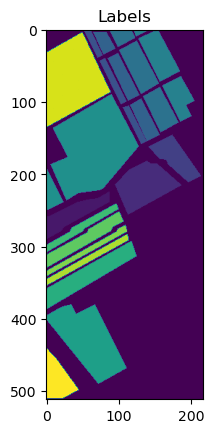

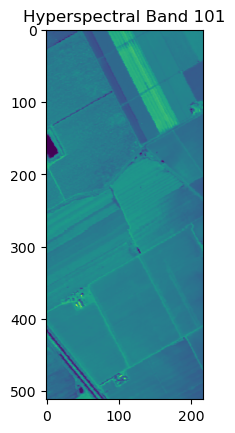

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices for clas


 -- Test set created with: 
	53969 samples
	shape (53969, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(80, 5, 5, 204)
(80, 5, 5, 204)
(53969, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1596, PSNR: 7.0707


	 Training Batch [200/677], Loss: 0.0896, PSNR: 9.2350


	 Training Batch [400/677], Loss: 0.0458, PSNR: 12.5786


	 Training Batch [600/677], Loss: 0.0243, PSNR: 14.9567


Epoch [1/50] Training Loss: 0.0679, PSNR: 11.5807
	[Val]   Batch [1/170] Loss: 0.0208, PSNR: 15.9155
	[Val]   Batch [10/170] Loss: 0.0204, PSNR: 16.0862
	[Val]   Batch [20/170] Loss: 0.0205, PSNR: 15.9893
	[Val]   Batch [30/170] Loss: 0.0213, PSNR: 15.7621
	[Val]   Batch [40/170] Loss: 0.0213, PSNR: 15.8470


	[Val]   Batch [50/170] Loss: 0.0202, PSNR: 16.0650
	[Val]   Batch [60/170] Loss: 0.0212, PSNR: 15.9275
	[Val]   Batch [70/170] Loss: 0.0207, PSNR: 16.0267
	[Val]   Batch [80/170] Loss: 0.0211, PSNR: 15.8353
	[Val]   Batch [90/170] Loss: 0.0204, PSNR: 16.0808


	[Val]   Batch [100/170] Loss: 0.0205, PSNR: 15.9902
	[Val]   Batch [110/170] Loss: 0.0204, PSNR: 15.9987
	[Val]   Batch [120/170] Loss: 0.0193, PSNR: 14.3007
	[Val]   Batch [130/170] Loss: 0.0204, PSNR: 16.0764
	[Val]   Batch [140/170] Loss: 0.0199, PSNR: 16.1473


	[Val]   Batch [150/170] Loss: 0.0214, PSNR: 15.8691
	[Val]   Batch [160/170] Loss: 0.0210, PSNR: 15.9205
	[Val]   Batch [170/170] Loss: 0.0219, PSNR: 15.1998
Epoch [1/50] Validation Loss: 0.0207, PSNR: 15.9043

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0202, PSNR: 16.0499


	 Training Batch [200/677], Loss: 0.0138, PSNR: 17.6419


	 Training Batch [400/677], Loss: 0.0107, PSNR: 18.7672


	 Training Batch [600/677], Loss: 0.0092, PSNR: 19.5270


Epoch [2/50] Training Loss: 0.0128, PSNR: 18.1746
	[Val]   Batch [1/170] Loss: 0.0085, PSNR: 19.8009
	[Val]   Batch [10/170] Loss: 0.0080, PSNR: 20.1376
	[Val]   Batch [20/170] Loss: 0.0081, PSNR: 20.0054
	[Val]   Batch [30/170] Loss: 0.0088, PSNR: 19.6100
	[Val]   Batch [40/170] Loss: 0.0090, PSNR: 19.6052


	[Val]   Batch [50/170] Loss: 0.0079, PSNR: 20.1617
	[Val]   Batch [60/170] Loss: 0.0088, PSNR: 19.7460
	[Val]   Batch [70/170] Loss: 0.0086, PSNR: 19.8534
	[Val]   Batch [80/170] Loss: 0.0086, PSNR: 19.7039


	[Val]   Batch [90/170] Loss: 0.0083, PSNR: 19.9966
	[Val]   Batch [100/170] Loss: 0.0083, PSNR: 19.9098
	[Val]   Batch [110/170] Loss: 0.0082, PSNR: 19.9807
	[Val]   Batch [120/170] Loss: 0.0071, PSNR: 18.6183
	[Val]   Batch [130/170] Loss: 0.0083, PSNR: 20.0001


	[Val]   Batch [140/170] Loss: 0.0077, PSNR: 20.2862
	[Val]   Batch [150/170] Loss: 0.0090, PSNR: 19.6406
	[Val]   Batch [160/170] Loss: 0.0087, PSNR: 19.7415
	[Val]   Batch [170/170] Loss: 0.0090, PSNR: 19.0571
Epoch [2/50] Validation Loss: 0.0084, PSNR: 19.8413

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0079, PSNR: 20.1050


	 Training Batch [200/677], Loss: 0.0067, PSNR: 20.8318


	 Training Batch [400/677], Loss: 0.0063, PSNR: 21.0359


	 Training Batch [600/677], Loss: 0.0046, PSNR: 22.5579


Epoch [3/50] Training Loss: 0.0063, PSNR: 21.1405
	[Val]   Batch [1/170] Loss: 0.0046, PSNR: 22.4966
	[Val]   Batch [10/170] Loss: 0.0044, PSNR: 22.7650
	[Val]   Batch [20/170] Loss: 0.0044, PSNR: 22.6755
	[Val]   Batch [30/170] Loss: 0.0048, PSNR: 22.2526
	[Val]   Batch [40/170] Loss: 0.0049, PSNR: 22.2735


	[Val]   Batch [50/170] Loss: 0.0043, PSNR: 22.7576
	[Val]   Batch [60/170] Loss: 0.0048, PSNR: 22.4030
	[Val]   Batch [70/170] Loss: 0.0046, PSNR: 22.5478
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3916
	[Val]   Batch [90/170] Loss: 0.0045, PSNR: 22.6349


	[Val]   Batch [100/170] Loss: 0.0046, PSNR: 22.4941
	[Val]   Batch [110/170] Loss: 0.0045, PSNR: 22.6080
	[Val]   Batch [120/170] Loss: 0.0040, PSNR: 21.1864
	[Val]   Batch [130/170] Loss: 0.0045, PSNR: 22.6113


	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.9537
	[Val]   Batch [150/170] Loss: 0.0049, PSNR: 22.3043
	[Val]   Batch [160/170] Loss: 0.0047, PSNR: 22.4247
	[Val]   Batch [170/170] Loss: 0.0048, PSNR: 21.8106
Epoch [3/50] Validation Loss: 0.0045, PSNR: 22.5029

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0042, PSNR: 22.4027


	 Training Batch [200/677], Loss: 0.0041, PSNR: 22.5340


	 Training Batch [400/677], Loss: 0.0036, PSNR: 23.5317


	 Training Batch [600/677], Loss: 0.0033, PSNR: 23.9674


Epoch [4/50] Training Loss: 0.0036, PSNR: 23.5773
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.8008
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0056
	[Val]   Batch [20/170] Loss: 0.0026, PSNR: 24.8901
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4435
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.6487


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9226
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.6685
	[Val]   Batch [70/170] Loss: 0.0027, PSNR: 24.9172
	[Val]   Batch [80/170] Loss: 0.0027, PSNR: 24.6987
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.9083


	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6366
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9146
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.2159
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7312
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.1958


	[Val]   Batch [150/170] Loss: 0.0029, PSNR: 24.5914
	[Val]   Batch [160/170] Loss: 0.0028, PSNR: 24.7449
	[Val]   Batch [170/170] Loss: 0.0029, PSNR: 24.0045
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7430

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0028, PSNR: 24.5374


	 Training Batch [200/677], Loss: 0.0023, PSNR: 25.0206


	 Training Batch [400/677], Loss: 0.0024, PSNR: 25.3174


	 Training Batch [600/677], Loss: 0.0021, PSNR: 25.8273


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3401
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.4045
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6403
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.4582
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9814
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.3278


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.4557
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2571
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.5688
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.3310
	[Val]   Batch [90/170] Loss: 0.0018, PSNR: 26.5041


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1503
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.6117
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6784
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.2280
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7986


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.2047
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.3565
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6369
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.3315

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0023, PSNR: 25.5947


	 Training Batch [200/677], Loss: 0.0020, PSNR: 26.2357


	 Training Batch [400/677], Loss: 0.0019, PSNR: 26.3555


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.0528


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5532
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6588
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.8956
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6538
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.1402
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6333


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6708
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4661
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 27.8782
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5647
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7652


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2927
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9783
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.8530
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3719
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0709


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.3873
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6024
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8549
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5502

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0017, PSNR: 26.7913


	 Training Batch [200/677], Loss: 0.0016, PSNR: 26.9258


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.5538


	 Training Batch [600/677], Loss: 0.0013, PSNR: 28.0057


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.4962
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6590
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8933
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5947
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0626
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6847


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5924
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4369
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9390
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.5636
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7832


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2216
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0775
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7383
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3031
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0762


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3419
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.6004
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.8520
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5235

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.1573


	 Training Batch [200/677], Loss: 0.0016, PSNR: 27.0962


	 Training Batch [400/677], Loss: 0.0013, PSNR: 27.8898


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.8084


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2721
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6083
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.8416
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5038
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9391
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6734
	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.4380


	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3432
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9391
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5169
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7447
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1023


	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.1023
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5874
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1849
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.0352
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2390


	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5431
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8420
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4484

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0011, PSNR: 28.9275


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.5081


	 Training Batch [400/677], Loss: 0.0010, PSNR: 28.9906


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.3687


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9700
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.5017
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.7481
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.3834
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 29.7956
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.5909


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.2574
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.2323
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.8602
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.4544
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.6915


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9758
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.0664
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.4109
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0730
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.9505


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.1225
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.4165
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.8224
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.3398

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.4351


	 Training Batch [200/677], Loss: 0.0008, PSNR: 29.8685


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.0498


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5284


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6187
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0629
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.4255
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0155
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.4097
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1790


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.8848
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8311
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4036
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0915
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.3398


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.6488
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 31.7005
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0732
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.7167
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6143


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7098
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9607
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.4740
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.9449

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.8499


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9276


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.3284


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.2898


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2184
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.9100
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.2404
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7841
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2842
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.0307


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.6564
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6861
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2070
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9765
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.2228


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5232
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.5597
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8398
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5823
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.4350


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.6032
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.7701
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.4038
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7754

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.4014


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.8916


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.5105


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.0995


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7495
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.4177
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.7253
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.2574
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.8509
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.5285


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1320
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.2394
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.6706
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.5177
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.7977


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.1281
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.0459
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.3609
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.1889
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.9036


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.1450
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.2473
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 32.0481
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.2960

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1571


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.3116


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4611


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1775


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.2317
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.1566
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.5726
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.0213
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.6800
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.2916


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.8606
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.0540
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.3626
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.3402


	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.6472
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.0023
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.8452
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.1709
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.0594


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.7105
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.9875
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.9641
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 33.0608
Epoch [13/50] Validation Loss: 0.0004, PSNR: 33.0943

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.2947


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.3561


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.6953


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.9083


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.6465
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.6916
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.0906
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.5306
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.2997
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.8297


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.2718
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.6820
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.8728
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.9695
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.2591


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.6289
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.3780
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.6049
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.7239


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.2141
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.6918
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.4881
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.7989
Epoch [14/50] Validation Loss: 0.0003, PSNR: 33.6600

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.8106


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.5739


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.2630


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9135


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9964
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0892
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.5461
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.9421
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.7709
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.2395


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.7035
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.1342
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.2092
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.4235
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.7321


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.1288
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.7894
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0385
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.1946
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.6533


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.1198
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8505
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3563
Epoch [15/50] Validation Loss: 0.0003, PSNR: 34.0920

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3085


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.6479


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.2692


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.7964


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3027
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.4885
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.9938
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3292
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.1975
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6392


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.0493
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5668
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.5926
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8368
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.1655


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6154
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.1912
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.4557
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.6822
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0515


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.6055
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2331
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8533
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5078

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.9479


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.0090


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9083


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.6029


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6038
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.8545
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2806
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.5828
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5515
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.9930


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4188
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9275
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9017
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.1601
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5810


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9713
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.5189
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.8263
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0173


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4059
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9262
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5325
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.0324
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.8253

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4189


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4399


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0393


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.8498


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8194
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.9769
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4159
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7228
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.6852
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0686


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5747
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.0846
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0277
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2757
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7658


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1394
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6279
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 33.0188
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.1831
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5533


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.0370
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6269
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.0912
Epoch [18/50] Validation Loss: 0.0003, PSNR: 34.9500

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1042


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.5701


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.6383


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.6850


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0691
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.5883
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.9444
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.2374
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.2759
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.6374


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9852
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.7265
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.5814
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.9772
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.3593


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.7270
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.2172
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4282
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.8182
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.0854


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.6876
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 35.1383
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.9995
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.5341
Early stopping triggered at epoch 19. No improvement for 3 epochs.


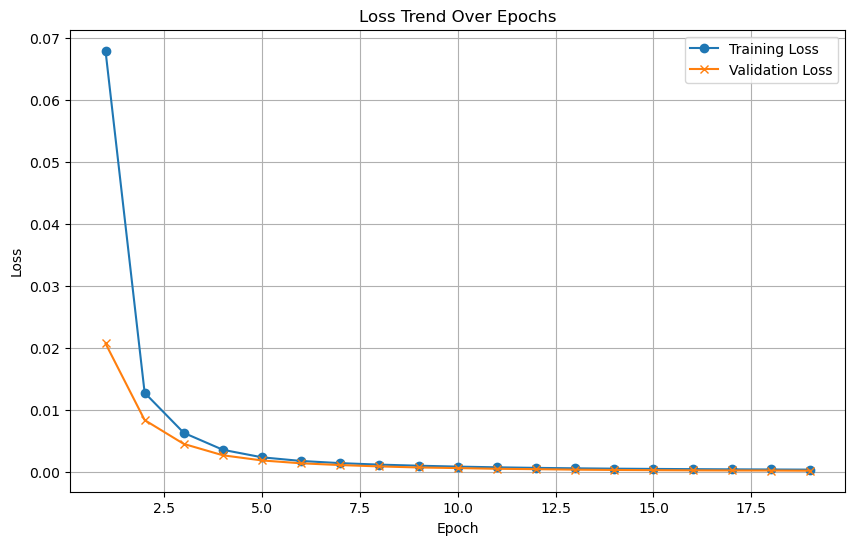

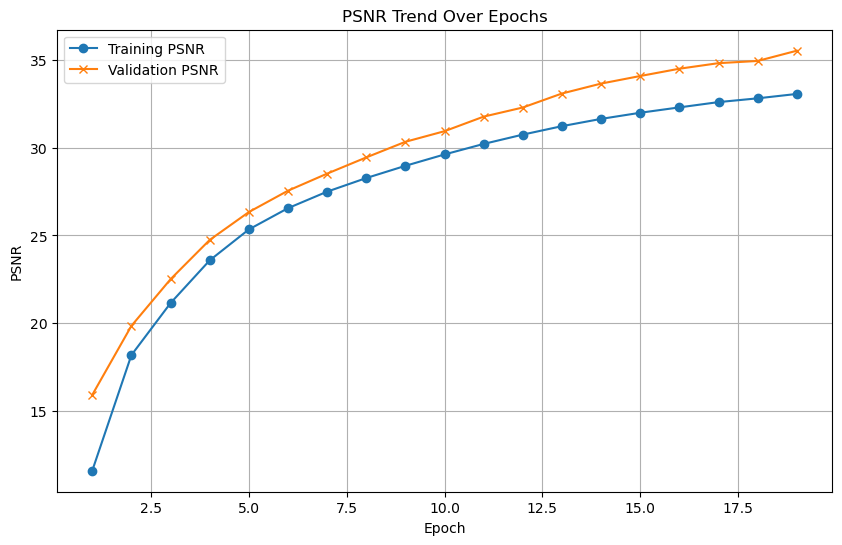

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7840
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7799. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7205
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Validation Accuracy: 6.25%
Validation loss improved from 2.7799 to 2.7799. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6921
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Validation Accuracy: 6.25%
Validation loss improved from 2.7799 to 2.7799. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6818
    Validation Batch [1/1], Loss: 2.7799
Validation Loss: 2.7799, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Epoch 

    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.25%
Validation loss improved from 2.7798 to 2.7795. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4770
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.25%
Validation loss improved from 2.7795 to 2.7793. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4706
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.25%
Validation loss improved from 2.7793 to 2.7791. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4369
    Validation Batch [1/1], Loss: 2.7788
Validation Loss: 2.7788, Validation Accuracy: 6.25%
Validation loss improved from 2.7791 to 2.7788. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4329
    Validati

Epoch [49/1000] completed, Average Training Loss: 2.1835
    Validation Batch [1/1], Loss: 2.6228
Validation Loss: 2.6228, Validation Accuracy: 20.00%
Validation loss improved from 2.6405 to 2.6228. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2099
    Validation Batch [1/1], Loss: 2.6054
Validation Loss: 2.6054, Validation Accuracy: 20.00%
Validation loss improved from 2.6228 to 2.6054. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.1986
    Validation Batch [1/1], Loss: 2.5889
Validation Loss: 2.5889, Validation Accuracy: 21.25%
Validation loss improved from 2.6054 to 2.5889. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.1474
    Validation Batch [1/1], Loss: 2.5670
Validation Loss: 2.5670, Validation Accuracy: 22.50%
Validation loss improved from 2.5889 to 2.5670. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.1190
Validation Loss: 2.1190, Validation Accuracy: 47.50%
Validation loss improved from 2.1209 to 2.1190. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.9645
    Validation Batch [1/1], Loss: 2.1001
Validation Loss: 2.1001, Validation Accuracy: 47.50%
Validation loss improved from 2.1190 to 2.1001. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.9121
    Validation Batch [1/1], Loss: 2.0722
Validation Loss: 2.0722, Validation Accuracy: 50.00%
Validation loss improved from 2.1001 to 2.0722. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.8978
    Validation Batch [1/1], Loss: 2.0637
Validation Loss: 2.0637, Validation Accuracy: 51.25%
Validation loss improved from 2.0722 to 2.0637. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.9257
    Vali

Validation Loss: 1.8186, Validation Accuracy: 65.00%
Validation loss improved from 1.8198 to 1.8186. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.7474
    Validation Batch [1/1], Loss: 1.8300
Validation Loss: 1.8300, Validation Accuracy: 67.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.7011
    Validation Batch [1/1], Loss: 1.8440
Validation Loss: 1.8440, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.6967
    Validation Batch [1/1], Loss: 1.8133
Validation Loss: 1.8133, Validation Accuracy: 67.50%
Validation loss improved from 1.8186 to 1.8133. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7127
    Validation Batch [1/1], Loss: 1.7921
Validation Loss: 1.7921, Valid

    Validation Batch [1/1], Loss: 1.6236
Validation Loss: 1.6236, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5119
    Validation Batch [1/1], Loss: 1.6096
Validation Loss: 1.6096, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.4477
    Validation Batch [1/1], Loss: 1.6090
Validation Loss: 1.6090, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4774
    Validation Batch [1/1], Loss: 1.5710
Validation Loss: 1.5710, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4197
    Validation Batch [1/1], Loss: 1.5726
Validation Loss: 1.

Epoch [169/1000] completed, Average Training Loss: 1.3183
    Validation Batch [1/1], Loss: 1.3712
Validation Loss: 1.3712, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.2705
    Validation Batch [1/1], Loss: 1.3348
Validation Loss: 1.3348, Validation Accuracy: 87.50%
Validation loss improved from 1.3687 to 1.3348. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2556
    Validation Batch [1/1], Loss: 1.3542
Validation Loss: 1.3542, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.3301
    Validation Batch [1/1], Loss: 1.3457
Validation Loss: 1.3457, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.1503
Validation Loss: 1.1503, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9966
    Validation Batch [1/1], Loss: 1.1330
Validation Loss: 1.1330, Validation Accuracy: 86.25%
Validation loss improved from 1.1496 to 1.1330. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.0959
    Validation Batch [1/1], Loss: 1.1456
Validation Loss: 1.1456, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.1252
    Validation Batch [1/1], Loss: 1.1408
Validation Loss: 1.1408, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.0726
    Validation Batch [1/1], Loss: 1.1406
Vali

Epoch [230/1000] completed, Average Training Loss: 0.8703
    Validation Batch [1/1], Loss: 0.9401
Validation Loss: 0.9401, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.8813
    Validation Batch [1/1], Loss: 0.9342
Validation Loss: 0.9342, Validation Accuracy: 90.00%
Validation loss improved from 0.9399 to 0.9342. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.8933
    Validation Batch [1/1], Loss: 0.9404
Validation Loss: 0.9404, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.8432
    Validation Batch [1/1], Loss: 0.9328
Validation Loss: 0.9328, Validation Accuracy: 88.75%
Validation loss improved from 0.9342 to 0.9328. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Av

Epoch [259/1000] completed, Average Training Loss: 0.7381
    Validation Batch [1/1], Loss: 0.7406
Validation Loss: 0.7406, Validation Accuracy: 91.25%
Validation loss improved from 0.7577 to 0.7406. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6393
    Validation Batch [1/1], Loss: 0.7297
Validation Loss: 0.7297, Validation Accuracy: 91.25%
Validation loss improved from 0.7406 to 0.7297. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.7325
    Validation Batch [1/1], Loss: 0.7245
Validation Loss: 0.7245, Validation Accuracy: 90.00%
Validation loss improved from 0.7297 to 0.7245. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.6614
    Validation Batch [1/1], Loss: 0.7316
Validation Loss: 0.7316, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000

Epoch [287/1000] completed, Average Training Loss: 0.5028
    Validation Batch [1/1], Loss: 0.6250
Validation Loss: 0.6250, Validation Accuracy: 91.25%
Validation loss improved from 0.6293 to 0.6250. Saving model...

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.5372
    Validation Batch [1/1], Loss: 0.6295
Validation Loss: 0.6295, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.5869
    Validation Batch [1/1], Loss: 0.6347
Validation Loss: 0.6347, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.5099
    Validation Batch [1/1], Loss: 0.6055
Validation Loss: 0.6055, Validation Accuracy: 91.25%
Validation loss improved from 0.6250 to 0.6055. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Av

Epoch [317/1000] completed, Average Training Loss: 0.4506
    Validation Batch [1/1], Loss: 0.5135
Validation Loss: 0.5135, Validation Accuracy: 92.50%
Validation loss improved from 0.5200 to 0.5135. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.4087
    Validation Batch [1/1], Loss: 0.5154
Validation Loss: 0.5154, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.4754
    Validation Batch [1/1], Loss: 0.5288
Validation Loss: 0.5288, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3796
    Validation Batch [1/1], Loss: 0.5241
Validation Loss: 0.5241, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training 

Epoch [348/1000] completed, Average Training Loss: 0.3564
    Validation Batch [1/1], Loss: 0.4296
Validation Loss: 0.4296, Validation Accuracy: 92.50%
Validation loss improved from 0.4298 to 0.4296. Saving model...

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.3673
    Validation Batch [1/1], Loss: 0.4446
Validation Loss: 0.4446, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.3140
    Validation Batch [1/1], Loss: 0.4379
Validation Loss: 0.4379, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.3021
    Validation Batch [1/1], Loss: 0.4436
Validation Loss: 0.4436, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training 

Epoch [379/1000] completed, Average Training Loss: 0.2791
    Validation Batch [1/1], Loss: 0.3782
Validation Loss: 0.3782, Validation Accuracy: 92.50%
Validation loss improved from 0.3854 to 0.3782. Saving model...

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2816
    Validation Batch [1/1], Loss: 0.4028
Validation Loss: 0.4028, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.3115
    Validation Batch [1/1], Loss: 0.3878
Validation Loss: 0.3878, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2766
    Validation Batch [1/1], Loss: 0.3905
Validation Loss: 0.3905, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training 

Epoch [408/1000] completed, Average Training Loss: 0.1907
    Validation Batch [1/1], Loss: 0.3465
Validation Loss: 0.3465, Validation Accuracy: 92.50%
Validation loss improved from 0.3469 to 0.3465. Saving model...

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.2230
    Validation Batch [1/1], Loss: 0.3451
Validation Loss: 0.3451, Validation Accuracy: 92.50%
Validation loss improved from 0.3465 to 0.3451. Saving model...

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.2314
    Validation Batch [1/1], Loss: 0.3476
Validation Loss: 0.3476, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.2406
    Validation Batch [1/1], Loss: 0.3523
Validation Loss: 0.3523, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Av

Epoch [436/1000] completed, Average Training Loss: 0.1992
    Validation Batch [1/1], Loss: 0.3252
Validation Loss: 0.3252, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.3441
Validation Loss: 0.3441, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1850
    Validation Batch [1/1], Loss: 0.3517
Validation Loss: 0.3517, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1565
    Validation Batch [1/1], Loss: 0.3351
Validation Loss: 0.3351, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1421
 

Epoch [465/1000] completed, Average Training Loss: 0.1622
    Validation Batch [1/1], Loss: 0.3115
Validation Loss: 0.3115, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1681
    Validation Batch [1/1], Loss: 0.3075
Validation Loss: 0.3075, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1249
    Validation Batch [1/1], Loss: 0.3113
Validation Loss: 0.3113, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1410
    Validation Batch [1/1], Loss: 0.3162
Validation Loss: 0.3162, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1388
 

    Validation Batch [1/1], Loss: 0.2899
Validation Loss: 0.2899, Validation Accuracy: 92.50%
Validation loss improved from 0.2913 to 0.2899. Saving model...

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1354
    Validation Batch [1/1], Loss: 0.2895
Validation Loss: 0.2895, Validation Accuracy: 92.50%
Validation loss improved from 0.2899 to 0.2895. Saving model...

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1360
    Validation Batch [1/1], Loss: 0.2937
Validation Loss: 0.2937, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.1308
    Validation Batch [1/1], Loss: 0.3067
Validation Loss: 0.3067, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.1361
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.2987
Validation Loss: 0.2987, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.1283
    Validation Batch [1/1], Loss: 0.3355
Validation Loss: 0.3355, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.3363
Validation Loss: 0.3363, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.1033
    Validation Batch [1/1], Loss: 0.3245
Validation Loss

    Validation Batch [1/1], Loss: 0.2824
Validation Loss: 0.2824, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.1039
    Validation Batch [1/1], Loss: 0.3319
Validation Loss: 0.3319, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.3112
Validation Loss: 0.3112, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0849
    Validation Batch [1/1], Loss: 0.2836
Validation Loss: 0.2836, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.2745
Validation Loss

Epoch [581/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.2728
Validation Loss: 0.2728, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 0.2989
Validation Loss: 0.2989, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0800
    Validation Batch [1/1], Loss: 0.2997
Validation Loss: 0.2997, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0711
    Validation Batch [1/1], Loss: 0.3044
Validation Loss: 0.3044, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.079

Epoch [612/1000] completed, Average Training Loss: 0.0844
    Validation Batch [1/1], Loss: 0.2795
Validation Loss: 0.2795, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0698
    Validation Batch [1/1], Loss: 0.2830
Validation Loss: 0.2830, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0787
    Validation Batch [1/1], Loss: 0.2833
Validation Loss: 0.2833, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.2868
Validation Loss: 0.2868, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0748
  

Epoch [640/1000] completed, Average Training Loss: 0.0772
    Validation Batch [1/1], Loss: 0.3100
Validation Loss: 0.3100, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 0.3054
Validation Loss: 0.3054, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.2833
Validation Loss: 0.2833, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0733
    Validation Batch [1/1], Loss: 0.2776
Validation Loss: 0.2776, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.057

Epoch [670/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.2718
Validation Loss: 0.2718, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0542
    Validation Batch [1/1], Loss: 0.2631
Validation Loss: 0.2631, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0942
    Validation Batch [1/1], Loss: 0.2586
Validation Loss: 0.2586, Validation Accuracy: 92.50%
Validation loss improved from 0.2604 to 0.2586. Saving model...

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.2615
Validation Loss: 0.2615, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Trainin

Epoch [698/1000] completed, Average Training Loss: 0.0685
    Validation Batch [1/1], Loss: 0.2764
Validation Loss: 0.2764, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.0737
    Validation Batch [1/1], Loss: 0.2728
Validation Loss: 0.2728, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.2684
Validation Loss: 0.2684, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [701/1000] - Training
Epoch [701/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.2733
Validation Loss: 0.2733, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [702/1000] - Training
Epoch [702/1000] completed, Average Training Loss: 0.056

Epoch [728/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.2592
Validation Loss: 0.2592, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.2672
Validation Loss: 0.2672, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.2894
Validation Loss: 0.2894, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0608
    Validation Batch [1/1], Loss: 0.2937
Validation Loss: 0.2937, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0555
  

    Validation Batch [1/1], Loss: 0.2689
Validation Loss: 0.2689, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.2660
Validation Loss: 0.2660, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [761/1000] - Training
Epoch [761/1000] completed, Average Training Loss: 0.0624
    Validation Batch [1/1], Loss: 0.2692
Validation Loss: 0.2692, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.2758
Validation Loss: 0.2758, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0359
    Validation Batch [1/1], Loss: 0.2897
Validation Loss

    Validation Batch [1/1], Loss: 0.3155
Validation Loss: 0.3155, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [791/1000] - Training
Epoch [791/1000] completed, Average Training Loss: 0.0594
    Validation Batch [1/1], Loss: 0.3148
Validation Loss: 0.3148, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.3190
Validation Loss: 0.3190, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.0470
    Validation Batch [1/1], Loss: 0.3303
Validation Loss: 0.3303, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [794/1000] - Training
Epoch [794/1000] completed, Average Training Loss: 0.0405
    Validation Batch [1/1], Loss: 0.3209
Validation Loss

Epoch [819/1000] completed, Average Training Loss: 0.0608
    Validation Batch [1/1], Loss: 0.4498
Validation Loss: 0.4498, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [820/1000] - Training
Epoch [820/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.3180
Validation Loss: 0.3180, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [821/1000] - Training
Epoch [821/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.7595
Validation Loss: 0.7595, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [822/1000] - Training
Epoch [822/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.3837
Validation Loss: 0.3837, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [823/1000] - Training
Epoch [823/1000] completed, Average Training Loss: 0.031

Epoch [848/1000] completed, Average Training Loss: 0.0762
    Validation Batch [1/1], Loss: 0.4237
Validation Loss: 0.4237, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [849/1000] - Training
Epoch [849/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.3653
Validation Loss: 0.3653, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.0690
    Validation Batch [1/1], Loss: 0.3379
Validation Loss: 0.3379, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.3187
Validation Loss: 0.3187, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.045

    Validation Batch [1/1], Loss: 0.3076
Validation Loss: 0.3076, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.3464
Validation Loss: 0.3464, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [880/1000] - Training
Epoch [880/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.3898
Validation Loss: 0.3898, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.3472
Validation Loss: 0.3472, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [882/1000] - Training
Epoch [882/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.3131
Validation Loss

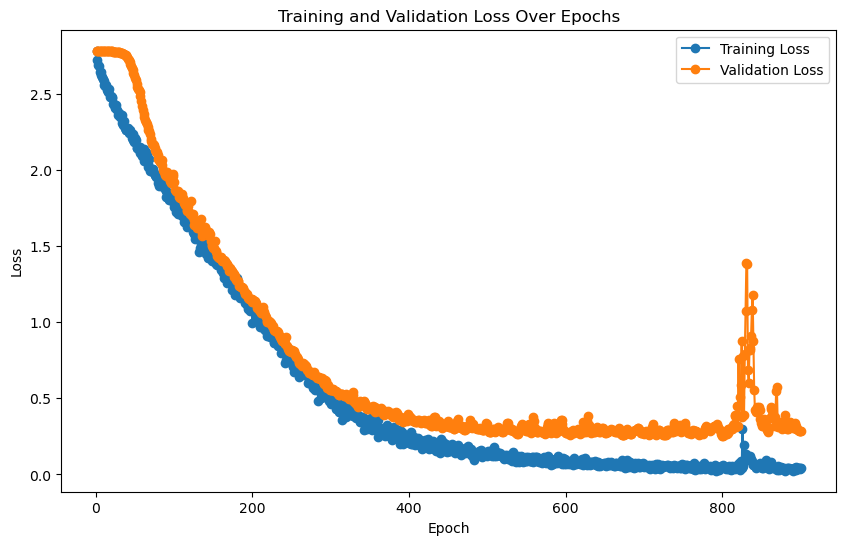

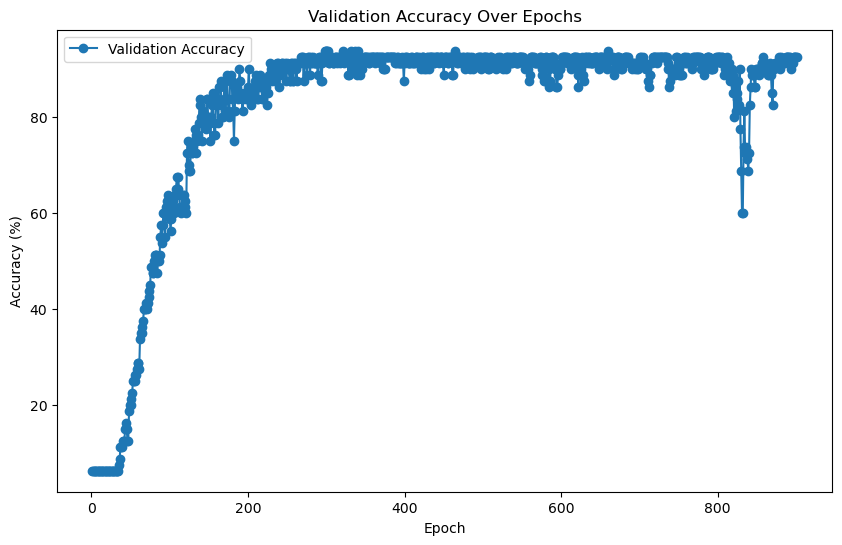


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.2429



Final Test Loss: 0.6840, Test Accuracy: 80.28%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.


  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53969, 64), Test labels shape: (53969,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.33      0.40      0.36         5
           8       0.67      0.80

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53969, 64)
Test labels shape: (53969,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8418  |  Val Loss: 2.7435
Validation loss improved from inf to 2.7435.
[Epoch 2/1000] Train Loss: 2.7198  |  Val Loss: 2.6452
Validation loss improved from 2.7435 to 2.6452.
[Epoch 3/1000] Train Loss: 2.6264  |  Val Loss: 2.5681
Validation loss improved from 2.6452 to 2.5681.
[Epoch 4/1000] Train Loss: 2.5483  |  Val Loss: 2.4988
Validation loss improved from 2.5681 to 2.4988.
[Epoch 5/1000] Train Loss: 2.4845  |  Val Loss: 2.4433
Validation loss improved from 2.4988 to 2.4433.
[Epoch 6/1000] Train Loss: 2.4235  |  Val Loss: 2.3945
Validation loss improved from 2.4433 to 2.3945.
[Epoch 7/1000] Train Loss: 2.3741  |  Val Loss: 2.3494
Validation loss improved from 2.3945 to 2.3494.
[Epoch 8/1000] Train Loss: 2.3284  |  Val Loss: 2.3051
Validation loss improved from 2.3494 to 2.3051.
[Epoch 9/1000] Train Loss: 2.2763  |  Val Loss: 2.2593
Validation loss improved from 2.3051 to 2.2593.
[Epoch 10/1000] Train Loss: 2.2257  |  Val Loss: 2.2099
Validation loss impr

[Epoch 29/1000] Train Loss: 1.2517  |  Val Loss: 1.3516
Validation loss improved from 1.3931 to 1.3516.
[Epoch 30/1000] Train Loss: 1.2090  |  Val Loss: 1.3188
Validation loss improved from 1.3516 to 1.3188.
[Epoch 31/1000] Train Loss: 1.1685  |  Val Loss: 1.2876
Validation loss improved from 1.3188 to 1.2876.
[Epoch 32/1000] Train Loss: 1.1306  |  Val Loss: 1.2535
Validation loss improved from 1.2876 to 1.2535.
[Epoch 33/1000] Train Loss: 1.0922  |  Val Loss: 1.2191
Validation loss improved from 1.2535 to 1.2191.
[Epoch 34/1000] Train Loss: 1.0516  |  Val Loss: 1.1825
Validation loss improved from 1.2191 to 1.1825.
[Epoch 35/1000] Train Loss: 1.0102  |  Val Loss: 1.1540
Validation loss improved from 1.1825 to 1.1540.
[Epoch 36/1000] Train Loss: 0.9728  |  Val Loss: 1.1331
Validation loss improved from 1.1540 to 1.1331.
[Epoch 37/1000] Train Loss: 0.9422  |  Val Loss: 1.0982
Validation loss improved from 1.1331 to 1.0982.
[Epoch 38/1000] Train Loss: 0.9135  |  Val Loss: 1.0634
Validati

[Epoch 41/1000] Train Loss: 0.8245  |  Val Loss: 1.0138
Validation loss improved from 1.0218 to 1.0138.
[Epoch 42/1000] Train Loss: 0.7975  |  Val Loss: 1.0181
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.7924  |  Val Loss: 1.0094
Validation loss improved from 1.0138 to 1.0094.
[Epoch 44/1000] Train Loss: 0.7684  |  Val Loss: 0.9628
Validation loss improved from 1.0094 to 0.9628.
[Epoch 45/1000] Train Loss: 0.7246  |  Val Loss: 0.9211
Validation loss improved from 0.9628 to 0.9211.
[Epoch 46/1000] Train Loss: 0.6981  |  Val Loss: 0.9022
Validation loss improved from 0.9211 to 0.9022.
[Epoch 47/1000] Train Loss: 0.6800  |  Val Loss: 0.8889
Validation loss improved from 0.9022 to 0.8889.
[Epoch 48/1000] Train Loss: 0.6640  |  Val Loss: 0.8823
Validation loss improved from 0.8889 to 0.8823.
[Epoch 49/1000] Train Loss: 0.6495  |  Val Loss: 0.8675
Validation loss improved from 0.8823 to 0.8675.
[Epoch 50/1000] Train Loss: 0.6241  |  Val Loss: 0.8533
Va

[Epoch 68/1000] Train Loss: 0.3905  |  Val Loss: 0.7162
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.3833  |  Val Loss: 0.7125
Validation loss improved from 0.7148 to 0.7125.
[Epoch 70/1000] Train Loss: 0.3801  |  Val Loss: 0.7011
Validation loss improved from 0.7125 to 0.7011.
[Epoch 71/1000] Train Loss: 0.3761  |  Val Loss: 0.6937
Validation loss improved from 0.7011 to 0.6937.
[Epoch 72/1000] Train Loss: 0.3601  |  Val Loss: 0.6940
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.3509  |  Val Loss: 0.6984
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.3503  |  Val Loss: 0.6861
Validation loss improved from 0.6937 to 0.6861.
[Epoch 75/1000] Train Loss: 0.3444  |  Val Loss: 0.6743
Validation loss improved from 0.6861 to 0.6743.
[Epoch 76/1000] Train Loss: 0.3459  |  Val Loss: 0.6742
Validation loss improved from 0.6743 to 0.6742.
[Epoch 77/1000] Train Loss: 0.3310  |  Val Los

[Epoch 81/1000] Train Loss: 0.3112  |  Val Loss: 0.6660
Validation loss improved from 0.6742 to 0.6660.
[Epoch 82/1000] Train Loss: 0.3002  |  Val Loss: 0.6676
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 0.2924  |  Val Loss: 0.6755
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.2972  |  Val Loss: 0.6769
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 0.2951  |  Val Loss: 0.6642
Validation loss improved from 0.6660 to 0.6642.
[Epoch 86/1000] Train Loss: 0.2806  |  Val Loss: 0.6577
Validation loss improved from 0.6642 to 0.6577.
[Epoch 87/1000] Train Loss: 0.2727  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.2766  |  Val Loss: 0.6647
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 0.2734  |  Val Loss: 0.6585
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 90/1000] Train Loss: 

[Epoch 107/1000] Train Loss: 0.2035  |  Val Loss: 0.6517
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 108/1000] Train Loss: 0.2032  |  Val Loss: 0.6444
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 109/1000] Train Loss: 0.1945  |  Val Loss: 0.6435
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 110/1000] Train Loss: 0.1858  |  Val Loss: 0.6270
Validation loss improved from 0.6317 to 0.6270.
[Epoch 111/1000] Train Loss: 0.1831  |  Val Loss: 0.6245
Validation loss improved from 0.6270 to 0.6245.
[Epoch 112/1000] Train Loss: 0.1851  |  Val Loss: 0.6307
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 0.1825  |  Val Loss: 0.6524
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 114/1000] Train Loss: 0.1771  |  Val Loss: 0.6655
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 115/1000] Train Loss: 0.1744  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 116

[Epoch 121/1000] Train Loss: 0.1658  |  Val Loss: 0.6652
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 0.1605  |  Val Loss: 0.6696
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 0.1613  |  Val Loss: 0.6511
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Train Loss: 0.1627  |  Val Loss: 0.6321
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 125/1000] Train Loss: 0.1590  |  Val Loss: 0.6349
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 126/1000] Train Loss: 0.1527  |  Val Loss: 0.6581
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 127/1000] Train Loss: 0.1433  |  Val Loss: 0.7110
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 0.1571  |  Val Loss: 0.7203
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 129/1000] Train Loss: 0.1610  |  Val Loss: 0.6665
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 148/1000] Train Loss: 0.1118  |  Val Loss: 0.6907
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 149/1000] Train Loss: 0.1139  |  Val Loss: 0.6996
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 150/1000] Train Loss: 0.1139  |  Val Loss: 0.6978
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 151/1000] Train Loss: 0.1089  |  Val Loss: 0.6954
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 152/1000] Train Loss: 0.1083  |  Val Loss: 0.6923
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 153/1000] Train Loss: 0.1069  |  Val Loss: 0.6905
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 154/1000] Train Loss: 0.1065  |  Val Loss: 0.6930
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 155/1000] Train Loss: 0.1041  |  Val Loss: 0.6993
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 156/1000] Train Loss: 0.1027  |  Val Loss: 0.6938
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.0977  |  Val Loss: 0.7062
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 161/1000] Train Loss: 0.1038  |  Val Loss: 0.7220
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 162/1000] Train Loss: 0.1018  |  Val Loss: 0.7116
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 163/1000] Train Loss: 0.0929  |  Val Loss: 0.6869
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 164/1000] Train Loss: 0.0909  |  Val Loss: 0.6782
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 165/1000] Train Loss: 0.0931  |  Val Loss: 0.6792
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 166/1000] Train Loss: 0.0962  |  Val Loss: 0.6868
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 167/1000] Train Loss: 0.0937  |  Val Loss: 0.7071
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 168/1000] Train Loss: 0.0899  |  Val Loss: 0.7131
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.0775  |  Val Loss: 0.7143
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 188/1000] Train Loss: 0.0742  |  Val Loss: 0.7347
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 189/1000] Train Loss: 0.0726  |  Val Loss: 0.7406
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 190/1000] Train Loss: 0.0689  |  Val Loss: 0.7359
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 191/1000] Train Loss: 0.0681  |  Val Loss: 0.7226
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 192/1000] Train Loss: 0.0677  |  Val Loss: 0.7118
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 193/1000] Train Loss: 0.0682  |  Val Loss: 0.7109
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 194/1000] Train Loss: 0.0656  |  Val Loss: 0.7302
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 195/1000] Train Loss: 0.0621  |  Val Loss: 0.7519
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.0651  |  Val Loss: 0.7492
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 198/1000] Train Loss: 0.0655  |  Val Loss: 0.7494
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 199/1000] Train Loss: 0.0648  |  Val Loss: 0.7470
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 200/1000] Train Loss: 0.0625  |  Val Loss: 0.7479
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 201/1000] Train Loss: 0.0613  |  Val Loss: 0.7360
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 202/1000] Train Loss: 0.0593  |  Val Loss: 0.7328
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 203/1000] Train Loss: 0.0622  |  Val Loss: 0.7409
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 204/1000] Train Loss: 0.0605  |  Val Loss: 0.7558
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 205/1000] Train Loss: 0.0581  |  Val Loss: 0.7563
!! Validation loss did NOT improve !! Patience:

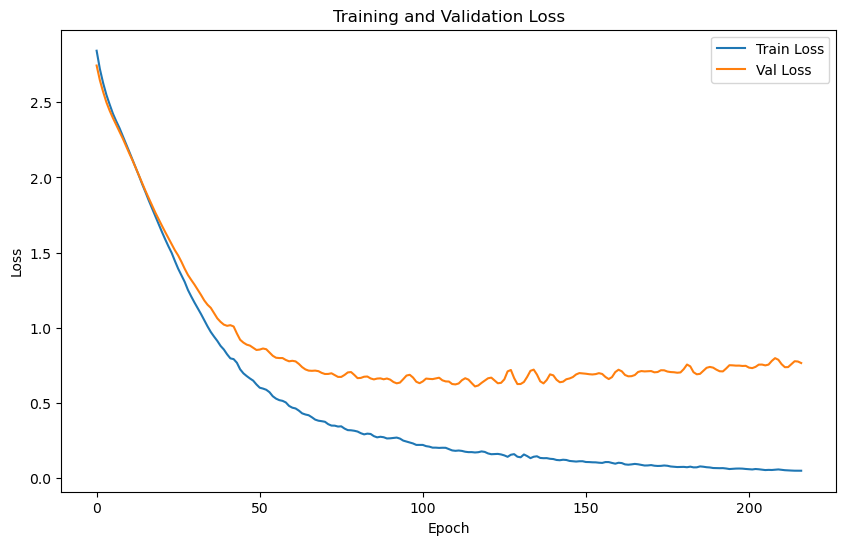

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.2300 | Test Accuracy: 72.80%


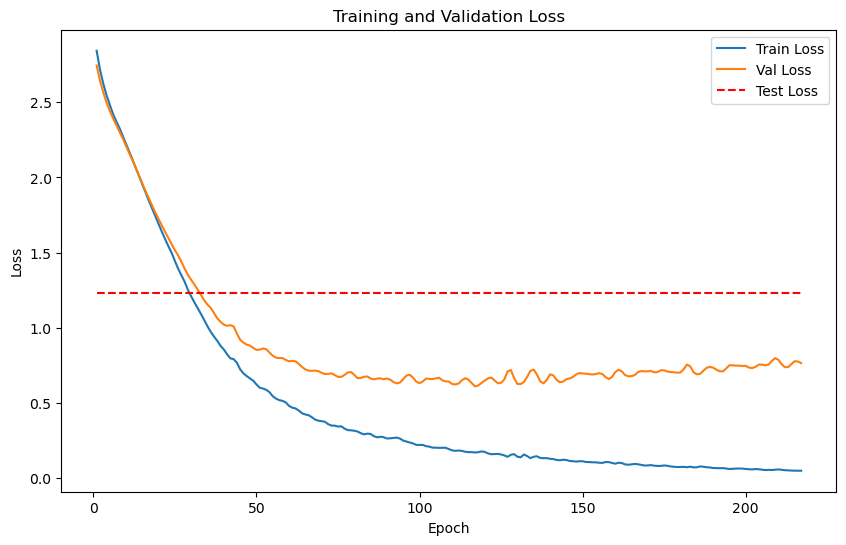

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7468
Epoch [1/2000], Avg Train Loss: 7.7468
Epoch [1/2000], Avg Val Loss: 3.0773
Validation loss improved from inf to 3.0773. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.1868
Epoch [2/2000], Avg Train Loss: 7.1868
Epoch [2/2000], Avg Val Loss: 3.0655
Validation loss improved from 3.0773 to 3.0655. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 7.1458
Epoch [3/2000], Avg Train Loss: 7.1458
Epoch [3/2000], Avg Val Loss: 3.0542
Validation loss improved from 3.0655 to 3.0542. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4534
Epoch [4/2000], Avg Train Loss: 7.4534
Epoch [4/2000], Avg Val Loss: 3.0434
Validation loss improved from 3.0542 to 3.0434. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.3439
Epoch [5/2000], Avg Train Loss: 7.3439
Epoch [5/2000], Avg Val Loss: 3.0330
Validation loss improved from 3.0434 to 3.0330. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.1109
Epoch [6/2000], Avg Train Loss: 7.1109
Epoch [6/2000], Avg Val Loss: 3.0229
Validation loss improved from 3.0330 to 3.0229. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.3855
Epoch [7/2000], Avg Train Loss: 7.3855
Epoch [7/2000], Avg Val Loss: 3.0132
Validation loss improved from 3.0229 to 3.0132. Saving m

Epoch [18/2000], Avg Val Loss: 2.9280
Validation loss improved from 2.9343 to 2.9280. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.2635
Epoch [19/2000], Avg Train Loss: 6.2635
Epoch [19/2000], Avg Val Loss: 2.9220
Validation loss improved from 2.9280 to 2.9220. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.6906
Epoch [20/2000], Avg Train Loss: 6.6906
Epoch [20/2000], Avg Val Loss: 2.9164
Validation loss improved from 2.9220 to 2.9164. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.6963
Epoch [21/2000], Avg Train Loss: 6.6963
Epoch [21/2000], Avg Val Loss: 2.9109
Validation loss improved from 2.9164 to 2.9109. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.5370
Epoch [22/2000], Avg Train Loss: 6.5370
Epoch [22/2000], Avg Val Loss: 2.9056
Validation loss improved from 2.9109 to 2.9056. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Trai

Epoch [26/2000], Avg Val Loss: 2.8871
Validation loss improved from 2.8912 to 2.8871. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.0418
Epoch [27/2000], Avg Train Loss: 6.0418
Epoch [27/2000], Avg Val Loss: 2.8832
Validation loss improved from 2.8871 to 2.8832. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.0852
Epoch [28/2000], Avg Train Loss: 6.0852
Epoch [28/2000], Avg Val Loss: 2.8794
Validation loss improved from 2.8832 to 2.8794. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.1220
Epoch [29/2000], Avg Train Loss: 6.1220
Epoch [29/2000], Avg Val Loss: 2.8758
Validation loss improved from 2.8794 to 2.8758. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.0610
Epoch [30/2000], Avg Train Loss: 6.0610
Epoch [30/2000], Avg Val Loss: 2.8724
Validation loss improved from 2.8758 to 2.8724. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3067
Epoch [50/2000], Avg Train Loss: 5.3067
Epoch [50/2000], Avg Val Loss: 2.8375
Validation loss improved from 2.8381 to 2.8375. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.0260
Epoch [51/2000], Avg Train Loss: 5.0260
Epoch [51/2000], Avg Val Loss: 2.8370
Validation loss improved from 2.8375 to 2.8370. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 4.8419
Epoch [52/2000], Avg Train Loss: 4.8419
Epoch [52/2000], Avg Val Loss: 2.8366
Validation loss improved from 2.8370 to 2.8366. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 4.9925
Epoch [53/2000], Avg Train Loss: 4.9925
Epoch [53/2000], Avg Val Loss: 2.8363
Validation loss improved from 2.8366 to 2.8363. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.0825
Epoch [54/2000], Avg Train Loss: 5.0825
Epoch [54/2000], Avg Val Loss: 2.8361
Validation loss improved from 2.8363 to 2.

    Batch [1/1], Train Loss: 4.4829
Epoch [68/2000], Avg Train Loss: 4.4829
Epoch [68/2000], Avg Val Loss: 2.8395
Validation loss did not improve. Patience: 12/100

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 4.7707
Epoch [69/2000], Avg Train Loss: 4.7707
Epoch [69/2000], Avg Val Loss: 2.8401
Validation loss did not improve. Patience: 13/100

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 4.5218
Epoch [70/2000], Avg Train Loss: 4.5218
Epoch [70/2000], Avg Val Loss: 2.8407
Validation loss did not improve. Patience: 14/100

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.4982
Epoch [71/2000], Avg Train Loss: 4.4982
Epoch [71/2000], Avg Val Loss: 2.8413
Validation loss did not improve. Patience: 15/100

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.5620
Epoch [72/2000], Avg Train Loss: 4.5620
Epoch [72/2000], Avg Val Loss: 2.8419
Validation loss did not improve. Patience: 16/100

LOG: Epoch [73/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.4180
Epoch [79/2000], Avg Train Loss: 4.4180
Epoch [79/2000], Avg Val Loss: 2.8472
Validation loss did not improve. Patience: 23/100

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.2371
Epoch [80/2000], Avg Train Loss: 4.2371
Epoch [80/2000], Avg Val Loss: 2.8480
Validation loss did not improve. Patience: 24/100

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.4159
Epoch [81/2000], Avg Train Loss: 4.4159
Epoch [81/2000], Avg Val Loss: 2.8488
Validation loss did not improve. Patience: 25/100

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.2566
Epoch [82/2000], Avg Train Loss: 4.2566
Epoch [82/2000], Avg Val Loss: 2.8496
Validation loss did not improve. Patience: 26/100

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.3083
Epoch [83/2000], Avg Train Loss: 4.3083
Epoch [83/2000], Avg Val Loss: 2.8504
Validation loss did not improve. Patience: 27/100

LOG: Epoch [84/2000] - Training
    Batch [1/1]

Epoch [100/2000], Avg Val Loss: 2.8658
Validation loss did not improve. Patience: 44/100

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.0793
Epoch [101/2000], Avg Train Loss: 4.0793
Epoch [101/2000], Avg Val Loss: 2.8666
Validation loss did not improve. Patience: 45/100

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.0481
Epoch [102/2000], Avg Train Loss: 4.0481
Epoch [102/2000], Avg Val Loss: 2.8674
Validation loss did not improve. Patience: 46/100

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 3.9694
Epoch [103/2000], Avg Train Loss: 3.9694
Epoch [103/2000], Avg Val Loss: 2.8681
Validation loss did not improve. Patience: 47/100

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.0994
Epoch [104/2000], Avg Train Loss: 4.0994
Epoch [104/2000], Avg Val Loss: 2.8689
Validation loss did not improve. Patience: 48/100

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.0254
Epoch [105/2000], Avg Train Loss: 4.0254


Epoch [113/2000], Avg Val Loss: 2.8747
Validation loss did not improve. Patience: 57/100

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 3.9595
Epoch [114/2000], Avg Train Loss: 3.9595
Epoch [114/2000], Avg Val Loss: 2.8753
Validation loss did not improve. Patience: 58/100

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 3.8413
Epoch [115/2000], Avg Train Loss: 3.8413
Epoch [115/2000], Avg Val Loss: 2.8758
Validation loss did not improve. Patience: 59/100

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.0409
Epoch [116/2000], Avg Train Loss: 4.0409
Epoch [116/2000], Avg Val Loss: 2.8764
Validation loss did not improve. Patience: 60/100

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 3.9011
Epoch [117/2000], Avg Train Loss: 3.9011
Epoch [117/2000], Avg Val Loss: 2.8770
Validation loss did not improve. Patience: 61/100

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 3.8837
Epoch [118/2000], Avg Train Loss: 3.8837


    Batch [1/1], Train Loss: 3.8595
Epoch [128/2000], Avg Train Loss: 3.8595
Epoch [128/2000], Avg Val Loss: 2.8816
Validation loss did not improve. Patience: 72/100

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 3.8269
Epoch [129/2000], Avg Train Loss: 3.8269
Epoch [129/2000], Avg Val Loss: 2.8820
Validation loss did not improve. Patience: 73/100

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 3.8557
Epoch [130/2000], Avg Train Loss: 3.8557
Epoch [130/2000], Avg Val Loss: 2.8824
Validation loss did not improve. Patience: 74/100

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 3.7113
Epoch [131/2000], Avg Train Loss: 3.7113
Epoch [131/2000], Avg Val Loss: 2.8827
Validation loss did not improve. Patience: 75/100

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 3.6203
Epoch [132/2000], Avg Train Loss: 3.6203
Epoch [132/2000], Avg Val Loss: 2.8830
Validation loss did not improve. Patience: 76/100

LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 3.6591
Epoch [145/2000], Avg Train Loss: 3.6591
Epoch [145/2000], Avg Val Loss: 2.8853
Validation loss did not improve. Patience: 89/100

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 3.6383
Epoch [146/2000], Avg Train Loss: 3.6383
Epoch [146/2000], Avg Val Loss: 2.8854
Validation loss did not improve. Patience: 90/100

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.6159
Epoch [147/2000], Avg Train Loss: 3.6159
Epoch [147/2000], Avg Val Loss: 2.8854
Validation loss did not improve. Patience: 91/100

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.7419
Epoch [148/2000], Avg Train Loss: 3.7419
Epoch [148/2000], Avg Val Loss: 2.8854
Validation loss did not improve. Patience: 92/100

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.6644
Epoch [149/2000], Avg Train Loss: 3.6644
Epoch [149/2000], Avg Val Loss: 2.8854
Validation loss did not improve. Patience: 93/100

LOG: Epoch [150/2000] - Training


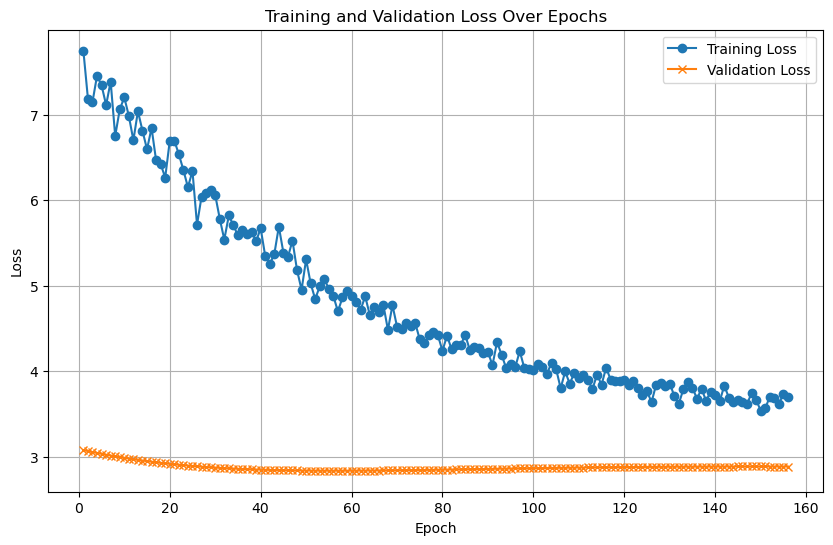

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 4.2949
Test Batch [20/211], Loss: 4.5901
Test Batch [30/211], Loss: 4.7549


Test Batch [40/211], Loss: 4.7610
Test Batch [50/211], Loss: 5.0063
Test Batch [60/211], Loss: 5.1352
Test Batch [70/211], Loss: 5.1802
Test Batch [80/211], Loss: 5.0445
Test Batch [90/211], Loss: 5.2195
Test Batch [100/211], Loss: 4.6056
Test Batch [110/211], Loss: 4.7344
Test Batch [120/211], Loss: 4.9432
Test Batch [130/211], Loss: 5.0142
Test Batch [140/211], Loss: 5.0413


Test Batch [150/211], Loss: 4.9895
Test Batch [160/211], Loss: 4.9544
Test Batch [170/211], Loss: 4.9565
Test Batch [180/211], Loss: 4.7439
Test Batch [190/211], Loss: 4.8454


Test Batch [200/211], Loss: 4.4441
Test Batch [210/211], Loss: 4.2508

Test Loss: 4.8130


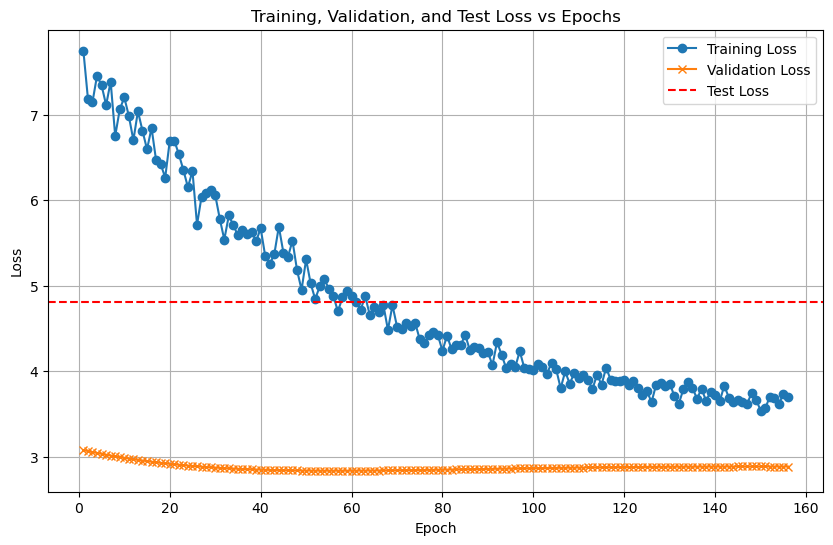

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.


  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.


  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.


  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.


  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.


  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.38      0.60      0.46         5
           8       1.00      1.00      1.00         5
           9       0.75      0.60      0.67         5
          10       1.00      0.80      0.89         5
          11       0.71      1.00      0.83         5
          12       0.80      0.80      0.80         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7798  |  Val Loss: 2.7800
Validation loss improved from inf to 2.7800.
[Epoch 2/1000] Train Loss: 2.7733  |  Val Loss: 2.7740
Validation loss improved from 2.7800 to 2.7740.
[Epoch 3/1000] Train Loss: 2.7674  |  Val Loss: 2.7685
Validation loss improved from 2.7740 to 2.7685.
[Epoch 4/1000] Train Loss: 2.7614  |  Val Loss: 2.7629
Validation loss improved from 2.7685 to 2.7629.
[Epoch 5/1000] Train Loss: 2.7563  |  Val Loss: 2.7574
Validation loss improved from 2.7629 to 2.7574.
[Epoch 6/1000] Train Loss: 2.7507  |  Val Loss: 2.7521
Validation loss improved from 2.7574 to 2.7521.
[Epoch 7/1000] Train Loss: 2.7452  |  Val Loss: 2.7468
Validation loss improved from 2.7521 to 2.7468.
[Epoch 8/1000] Train Loss: 2.7400  |  Val Loss: 2.7416
Validation loss improved from 2.7468 to 2.7416.
[Epoch 9/1000] Train Loss: 2.7348  |  Val Loss: 2.7365
Validation loss improved from 2.7416 to 2.7365.
[Epoch 10/1000] Train Loss: 2.7295  |  Val Loss: 2.7316
Validation loss impr

[Epoch 35/1000] Train Loss: 2.6131  |  Val Loss: 2.6163
Validation loss improved from 2.6203 to 2.6163.
[Epoch 36/1000] Train Loss: 2.6086  |  Val Loss: 2.6123
Validation loss improved from 2.6163 to 2.6123.
[Epoch 37/1000] Train Loss: 2.6042  |  Val Loss: 2.6080
Validation loss improved from 2.6123 to 2.6080.
[Epoch 38/1000] Train Loss: 2.6000  |  Val Loss: 2.6035
Validation loss improved from 2.6080 to 2.6035.
[Epoch 39/1000] Train Loss: 2.5951  |  Val Loss: 2.5990
Validation loss improved from 2.6035 to 2.5990.
[Epoch 40/1000] Train Loss: 2.5904  |  Val Loss: 2.5945
Validation loss improved from 2.5990 to 2.5945.
[Epoch 41/1000] Train Loss: 2.5858  |  Val Loss: 2.5901
Validation loss improved from 2.5945 to 2.5901.
[Epoch 42/1000] Train Loss: 2.5811  |  Val Loss: 2.5858
Validation loss improved from 2.5901 to 2.5858.
[Epoch 43/1000] Train Loss: 2.5762  |  Val Loss: 2.5813
Validation loss improved from 2.5858 to 2.5813.
[Epoch 44/1000] Train Loss: 2.5714  |  Val Loss: 2.5767
Validati

[Epoch 45/1000] Train Loss: 2.5666  |  Val Loss: 2.5718
Validation loss improved from 2.5767 to 2.5718.
[Epoch 46/1000] Train Loss: 2.5617  |  Val Loss: 2.5667
Validation loss improved from 2.5718 to 2.5667.
[Epoch 47/1000] Train Loss: 2.5565  |  Val Loss: 2.5616
Validation loss improved from 2.5667 to 2.5616.
[Epoch 48/1000] Train Loss: 2.5512  |  Val Loss: 2.5564
Validation loss improved from 2.5616 to 2.5564.
[Epoch 49/1000] Train Loss: 2.5461  |  Val Loss: 2.5513
Validation loss improved from 2.5564 to 2.5513.
[Epoch 50/1000] Train Loss: 2.5410  |  Val Loss: 2.5462
Validation loss improved from 2.5513 to 2.5462.
[Epoch 51/1000] Train Loss: 2.5361  |  Val Loss: 2.5411
Validation loss improved from 2.5462 to 2.5411.
[Epoch 52/1000] Train Loss: 2.5310  |  Val Loss: 2.5359
Validation loss improved from 2.5411 to 2.5359.
[Epoch 53/1000] Train Loss: 2.5258  |  Val Loss: 2.5307
Validation loss improved from 2.5359 to 2.5307.
[Epoch 54/1000] Train Loss: 2.5209  |  Val Loss: 2.5254
Validati

[Epoch 77/1000] Train Loss: 2.4083  |  Val Loss: 2.4126
Validation loss improved from 2.4177 to 2.4126.
[Epoch 78/1000] Train Loss: 2.4031  |  Val Loss: 2.4074
Validation loss improved from 2.4126 to 2.4074.
[Epoch 79/1000] Train Loss: 2.3980  |  Val Loss: 2.4020
Validation loss improved from 2.4074 to 2.4020.
[Epoch 80/1000] Train Loss: 2.3924  |  Val Loss: 2.3966
Validation loss improved from 2.4020 to 2.3966.
[Epoch 81/1000] Train Loss: 2.3871  |  Val Loss: 2.3911
Validation loss improved from 2.3966 to 2.3911.
[Epoch 82/1000] Train Loss: 2.3817  |  Val Loss: 2.3857
Validation loss improved from 2.3911 to 2.3857.
[Epoch 83/1000] Train Loss: 2.3765  |  Val Loss: 2.3803
Validation loss improved from 2.3857 to 2.3803.
[Epoch 84/1000] Train Loss: 2.3710  |  Val Loss: 2.3749
Validation loss improved from 2.3803 to 2.3749.
[Epoch 85/1000] Train Loss: 2.3655  |  Val Loss: 2.3695
Validation loss improved from 2.3749 to 2.3695.


[Epoch 86/1000] Train Loss: 2.3598  |  Val Loss: 2.3640
Validation loss improved from 2.3695 to 2.3640.
[Epoch 87/1000] Train Loss: 2.3544  |  Val Loss: 2.3584
Validation loss improved from 2.3640 to 2.3584.
[Epoch 88/1000] Train Loss: 2.3493  |  Val Loss: 2.3528
Validation loss improved from 2.3584 to 2.3528.
[Epoch 89/1000] Train Loss: 2.3440  |  Val Loss: 2.3473
Validation loss improved from 2.3528 to 2.3473.
[Epoch 90/1000] Train Loss: 2.3386  |  Val Loss: 2.3419
Validation loss improved from 2.3473 to 2.3419.
[Epoch 91/1000] Train Loss: 2.3331  |  Val Loss: 2.3368
Validation loss improved from 2.3419 to 2.3368.
[Epoch 92/1000] Train Loss: 2.3280  |  Val Loss: 2.3318
Validation loss improved from 2.3368 to 2.3318.
[Epoch 93/1000] Train Loss: 2.3229  |  Val Loss: 2.3266
Validation loss improved from 2.3318 to 2.3266.
[Epoch 94/1000] Train Loss: 2.3173  |  Val Loss: 2.3214
Validation loss improved from 2.3266 to 2.3214.
[Epoch 95/1000] Train Loss: 2.3122  |  Val Loss: 2.3161
Validati

[Epoch 120/1000] Train Loss: 2.1798  |  Val Loss: 2.1837
Validation loss improved from 2.1889 to 2.1837.
[Epoch 121/1000] Train Loss: 2.1742  |  Val Loss: 2.1786
Validation loss improved from 2.1837 to 2.1786.
[Epoch 122/1000] Train Loss: 2.1688  |  Val Loss: 2.1734
Validation loss improved from 2.1786 to 2.1734.
[Epoch 123/1000] Train Loss: 2.1638  |  Val Loss: 2.1681
Validation loss improved from 2.1734 to 2.1681.
[Epoch 124/1000] Train Loss: 2.1585  |  Val Loss: 2.1629
Validation loss improved from 2.1681 to 2.1629.
[Epoch 125/1000] Train Loss: 2.1530  |  Val Loss: 2.1575
Validation loss improved from 2.1629 to 2.1575.
[Epoch 126/1000] Train Loss: 2.1476  |  Val Loss: 2.1522
Validation loss improved from 2.1575 to 2.1522.
[Epoch 127/1000] Train Loss: 2.1421  |  Val Loss: 2.1468
Validation loss improved from 2.1522 to 2.1468.
[Epoch 128/1000] Train Loss: 2.1366  |  Val Loss: 2.1415
Validation loss improved from 2.1468 to 2.1415.


[Epoch 129/1000] Train Loss: 2.1309  |  Val Loss: 2.1361
Validation loss improved from 2.1415 to 2.1361.
[Epoch 130/1000] Train Loss: 2.1254  |  Val Loss: 2.1309
Validation loss improved from 2.1361 to 2.1309.
[Epoch 131/1000] Train Loss: 2.1198  |  Val Loss: 2.1257
Validation loss improved from 2.1309 to 2.1257.
[Epoch 132/1000] Train Loss: 2.1142  |  Val Loss: 2.1204
Validation loss improved from 2.1257 to 2.1204.
[Epoch 133/1000] Train Loss: 2.1085  |  Val Loss: 2.1151
Validation loss improved from 2.1204 to 2.1151.
[Epoch 134/1000] Train Loss: 2.1031  |  Val Loss: 2.1098
Validation loss improved from 2.1151 to 2.1098.
[Epoch 135/1000] Train Loss: 2.0974  |  Val Loss: 2.1046
Validation loss improved from 2.1098 to 2.1046.
[Epoch 136/1000] Train Loss: 2.0920  |  Val Loss: 2.0995
Validation loss improved from 2.1046 to 2.0995.
[Epoch 137/1000] Train Loss: 2.0862  |  Val Loss: 2.0944
Validation loss improved from 2.0995 to 2.0944.
[Epoch 138/1000] Train Loss: 2.0807  |  Val Loss: 2.089

[Epoch 160/1000] Train Loss: 1.9524  |  Val Loss: 1.9648
Validation loss improved from 1.9703 to 1.9648.
[Epoch 161/1000] Train Loss: 1.9465  |  Val Loss: 1.9594
Validation loss improved from 1.9648 to 1.9594.
[Epoch 162/1000] Train Loss: 1.9408  |  Val Loss: 1.9539
Validation loss improved from 1.9594 to 1.9539.
[Epoch 163/1000] Train Loss: 1.9352  |  Val Loss: 1.9484
Validation loss improved from 1.9539 to 1.9484.
[Epoch 164/1000] Train Loss: 1.9293  |  Val Loss: 1.9429
Validation loss improved from 1.9484 to 1.9429.
[Epoch 165/1000] Train Loss: 1.9233  |  Val Loss: 1.9374
Validation loss improved from 1.9429 to 1.9374.
[Epoch 166/1000] Train Loss: 1.9176  |  Val Loss: 1.9318
Validation loss improved from 1.9374 to 1.9318.
[Epoch 167/1000] Train Loss: 1.9116  |  Val Loss: 1.9262
Validation loss improved from 1.9318 to 1.9262.
[Epoch 168/1000] Train Loss: 1.9057  |  Val Loss: 1.9207
Validation loss improved from 1.9262 to 1.9207.


[Epoch 169/1000] Train Loss: 1.8998  |  Val Loss: 1.9155
Validation loss improved from 1.9207 to 1.9155.
[Epoch 170/1000] Train Loss: 1.8940  |  Val Loss: 1.9102
Validation loss improved from 1.9155 to 1.9102.
[Epoch 171/1000] Train Loss: 1.8883  |  Val Loss: 1.9049
Validation loss improved from 1.9102 to 1.9049.
[Epoch 172/1000] Train Loss: 1.8826  |  Val Loss: 1.8996
Validation loss improved from 1.9049 to 1.8996.
[Epoch 173/1000] Train Loss: 1.8766  |  Val Loss: 1.8943
Validation loss improved from 1.8996 to 1.8943.
[Epoch 174/1000] Train Loss: 1.8708  |  Val Loss: 1.8891
Validation loss improved from 1.8943 to 1.8891.
[Epoch 175/1000] Train Loss: 1.8649  |  Val Loss: 1.8839
Validation loss improved from 1.8891 to 1.8839.
[Epoch 176/1000] Train Loss: 1.8594  |  Val Loss: 1.8787
Validation loss improved from 1.8839 to 1.8787.
[Epoch 177/1000] Train Loss: 1.8536  |  Val Loss: 1.8735
Validation loss improved from 1.8787 to 1.8735.
[Epoch 178/1000] Train Loss: 1.8477  |  Val Loss: 1.868

[Epoch 198/1000] Train Loss: 1.7344  |  Val Loss: 1.7619
Validation loss improved from 1.7669 to 1.7619.
[Epoch 199/1000] Train Loss: 1.7291  |  Val Loss: 1.7571
Validation loss improved from 1.7619 to 1.7571.
[Epoch 200/1000] Train Loss: 1.7235  |  Val Loss: 1.7525
Validation loss improved from 1.7571 to 1.7525.
[Epoch 201/1000] Train Loss: 1.7185  |  Val Loss: 1.7480
Validation loss improved from 1.7525 to 1.7480.
[Epoch 202/1000] Train Loss: 1.7136  |  Val Loss: 1.7437
Validation loss improved from 1.7480 to 1.7437.
[Epoch 203/1000] Train Loss: 1.7104  |  Val Loss: 1.7392
Validation loss improved from 1.7437 to 1.7392.


[Epoch 204/1000] Train Loss: 1.7045  |  Val Loss: 1.7343
Validation loss improved from 1.7392 to 1.7343.
[Epoch 205/1000] Train Loss: 1.6988  |  Val Loss: 1.7294
Validation loss improved from 1.7343 to 1.7294.
[Epoch 206/1000] Train Loss: 1.6936  |  Val Loss: 1.7245
Validation loss improved from 1.7294 to 1.7245.
[Epoch 207/1000] Train Loss: 1.6883  |  Val Loss: 1.7196
Validation loss improved from 1.7245 to 1.7196.
[Epoch 208/1000] Train Loss: 1.6832  |  Val Loss: 1.7145
Validation loss improved from 1.7196 to 1.7145.
[Epoch 209/1000] Train Loss: 1.6777  |  Val Loss: 1.7094
Validation loss improved from 1.7145 to 1.7094.
[Epoch 210/1000] Train Loss: 1.6720  |  Val Loss: 1.7040
Validation loss improved from 1.7094 to 1.7040.
[Epoch 211/1000] Train Loss: 1.6662  |  Val Loss: 1.6988
Validation loss improved from 1.7040 to 1.6988.
[Epoch 212/1000] Train Loss: 1.6611  |  Val Loss: 1.6938
Validation loss improved from 1.6988 to 1.6938.
[Epoch 213/1000] Train Loss: 1.6555  |  Val Loss: 1.689

[Epoch 239/1000] Train Loss: 1.5265  |  Val Loss: 1.5738
Validation loss improved from 1.5779 to 1.5738.
[Epoch 240/1000] Train Loss: 1.5217  |  Val Loss: 1.5698
Validation loss improved from 1.5738 to 1.5698.
[Epoch 241/1000] Train Loss: 1.5169  |  Val Loss: 1.5660
Validation loss improved from 1.5698 to 1.5660.
[Epoch 242/1000] Train Loss: 1.5124  |  Val Loss: 1.5621
Validation loss improved from 1.5660 to 1.5621.
[Epoch 243/1000] Train Loss: 1.5076  |  Val Loss: 1.5582
Validation loss improved from 1.5621 to 1.5582.
[Epoch 244/1000] Train Loss: 1.5032  |  Val Loss: 1.5541
Validation loss improved from 1.5582 to 1.5541.
[Epoch 245/1000] Train Loss: 1.4986  |  Val Loss: 1.5500
Validation loss improved from 1.5541 to 1.5500.
[Epoch 246/1000] Train Loss: 1.4937  |  Val Loss: 1.5459
Validation loss improved from 1.5500 to 1.5459.
[Epoch 247/1000] Train Loss: 1.4895  |  Val Loss: 1.5418
Validation loss improved from 1.5459 to 1.5418.
[Epoch 248/1000] Train Loss: 1.4848  |  Val Loss: 1.537

[Epoch 283/1000] Train Loss: 1.3341  |  Val Loss: 1.4063
Validation loss improved from 1.4098 to 1.4063.
[Epoch 284/1000] Train Loss: 1.3300  |  Val Loss: 1.4027
Validation loss improved from 1.4063 to 1.4027.
[Epoch 285/1000] Train Loss: 1.3257  |  Val Loss: 1.3991
Validation loss improved from 1.4027 to 1.3991.
[Epoch 286/1000] Train Loss: 1.3217  |  Val Loss: 1.3955
Validation loss improved from 1.3991 to 1.3955.
[Epoch 287/1000] Train Loss: 1.3177  |  Val Loss: 1.3921
Validation loss improved from 1.3955 to 1.3921.
[Epoch 288/1000] Train Loss: 1.3140  |  Val Loss: 1.3885
Validation loss improved from 1.3921 to 1.3885.
[Epoch 289/1000] Train Loss: 1.3099  |  Val Loss: 1.3846
Validation loss improved from 1.3885 to 1.3846.
[Epoch 290/1000] Train Loss: 1.3063  |  Val Loss: 1.3809
Validation loss improved from 1.3846 to 1.3809.
[Epoch 291/1000] Train Loss: 1.3024  |  Val Loss: 1.3773
Validation loss improved from 1.3809 to 1.3773.
[Epoch 292/1000] Train Loss: 1.2978  |  Val Loss: 1.374

[Epoch 324/1000] Train Loss: 1.1760  |  Val Loss: 1.2736
Validation loss improved from 1.2762 to 1.2736.
[Epoch 325/1000] Train Loss: 1.1726  |  Val Loss: 1.2705
Validation loss improved from 1.2736 to 1.2705.
[Epoch 326/1000] Train Loss: 1.1690  |  Val Loss: 1.2674
Validation loss improved from 1.2705 to 1.2674.
[Epoch 327/1000] Train Loss: 1.1651  |  Val Loss: 1.2643
Validation loss improved from 1.2674 to 1.2643.
[Epoch 328/1000] Train Loss: 1.1613  |  Val Loss: 1.2611
Validation loss improved from 1.2643 to 1.2611.
[Epoch 329/1000] Train Loss: 1.1575  |  Val Loss: 1.2580
Validation loss improved from 1.2611 to 1.2580.
[Epoch 330/1000] Train Loss: 1.1542  |  Val Loss: 1.2547
Validation loss improved from 1.2580 to 1.2547.
[Epoch 331/1000] Train Loss: 1.1510  |  Val Loss: 1.2514
Validation loss improved from 1.2547 to 1.2514.
[Epoch 332/1000] Train Loss: 1.1474  |  Val Loss: 1.2480
Validation loss improved from 1.2514 to 1.2480.
[Epoch 333/1000] Train Loss: 1.1440  |  Val Loss: 1.244

[Epoch 362/1000] Train Loss: 1.0492  |  Val Loss: 1.1620
Validation loss improved from 1.1647 to 1.1620.
[Epoch 363/1000] Train Loss: 1.0459  |  Val Loss: 1.1595
Validation loss improved from 1.1620 to 1.1595.
[Epoch 364/1000] Train Loss: 1.0425  |  Val Loss: 1.1573
Validation loss improved from 1.1595 to 1.1573.
[Epoch 365/1000] Train Loss: 1.0401  |  Val Loss: 1.1557
Validation loss improved from 1.1573 to 1.1557.
[Epoch 366/1000] Train Loss: 1.0380  |  Val Loss: 1.1539
Validation loss improved from 1.1557 to 1.1539.
[Epoch 367/1000] Train Loss: 1.0354  |  Val Loss: 1.1519
Validation loss improved from 1.1539 to 1.1519.
[Epoch 368/1000] Train Loss: 1.0330  |  Val Loss: 1.1496
Validation loss improved from 1.1519 to 1.1496.
[Epoch 369/1000] Train Loss: 1.0297  |  Val Loss: 1.1464
Validation loss improved from 1.1496 to 1.1464.
[Epoch 370/1000] Train Loss: 1.0267  |  Val Loss: 1.1430
Validation loss improved from 1.1464 to 1.1430.
[Epoch 371/1000] Train Loss: 1.0226  |  Val Loss: 1.140

[Epoch 403/1000] Train Loss: 0.9321  |  Val Loss: 1.0631
Validation loss improved from 1.0669 to 1.0631.
[Epoch 404/1000] Train Loss: 0.9271  |  Val Loss: 1.0595
Validation loss improved from 1.0631 to 1.0595.
[Epoch 405/1000] Train Loss: 0.9252  |  Val Loss: 1.0569
Validation loss improved from 1.0595 to 1.0569.
[Epoch 406/1000] Train Loss: 0.9207  |  Val Loss: 1.0544
Validation loss improved from 1.0569 to 1.0544.
[Epoch 407/1000] Train Loss: 0.9183  |  Val Loss: 1.0516
Validation loss improved from 1.0544 to 1.0516.
[Epoch 408/1000] Train Loss: 0.9159  |  Val Loss: 1.0486
Validation loss improved from 1.0516 to 1.0486.
[Epoch 409/1000] Train Loss: 0.9130  |  Val Loss: 1.0458
Validation loss improved from 1.0486 to 1.0458.
[Epoch 410/1000] Train Loss: 0.9099  |  Val Loss: 1.0433
Validation loss improved from 1.0458 to 1.0433.
[Epoch 411/1000] Train Loss: 0.9074  |  Val Loss: 1.0410
Validation loss improved from 1.0433 to 1.0410.
[Epoch 412/1000] Train Loss: 0.9048  |  Val Loss: 1.039

[Epoch 445/1000] Train Loss: 0.8237  |  Val Loss: 0.9738
Validation loss improved from 0.9753 to 0.9738.
[Epoch 446/1000] Train Loss: 0.8208  |  Val Loss: 0.9723
Validation loss improved from 0.9738 to 0.9723.
[Epoch 447/1000] Train Loss: 0.8186  |  Val Loss: 0.9708
Validation loss improved from 0.9723 to 0.9708.
[Epoch 448/1000] Train Loss: 0.8159  |  Val Loss: 0.9691
Validation loss improved from 0.9708 to 0.9691.
[Epoch 449/1000] Train Loss: 0.8136  |  Val Loss: 0.9676
Validation loss improved from 0.9691 to 0.9676.
[Epoch 450/1000] Train Loss: 0.8115  |  Val Loss: 0.9662
Validation loss improved from 0.9676 to 0.9662.
[Epoch 451/1000] Train Loss: 0.8093  |  Val Loss: 0.9646
Validation loss improved from 0.9662 to 0.9646.
[Epoch 452/1000] Train Loss: 0.8071  |  Val Loss: 0.9630
Validation loss improved from 0.9646 to 0.9630.
[Epoch 453/1000] Train Loss: 0.8052  |  Val Loss: 0.9614
Validation loss improved from 0.9630 to 0.9614.
[Epoch 454/1000] Train Loss: 0.8027  |  Val Loss: 0.958

[Epoch 485/1000] Train Loss: 0.7396  |  Val Loss: 0.9086
Validation loss improved from 0.9112 to 0.9086.
[Epoch 486/1000] Train Loss: 0.7368  |  Val Loss: 0.9059
Validation loss improved from 0.9086 to 0.9059.
[Epoch 487/1000] Train Loss: 0.7341  |  Val Loss: 0.9038
Validation loss improved from 0.9059 to 0.9038.
[Epoch 488/1000] Train Loss: 0.7324  |  Val Loss: 0.9018
Validation loss improved from 0.9038 to 0.9018.
[Epoch 489/1000] Train Loss: 0.7307  |  Val Loss: 0.9001
Validation loss improved from 0.9018 to 0.9001.
[Epoch 490/1000] Train Loss: 0.7289  |  Val Loss: 0.8981
Validation loss improved from 0.9001 to 0.8981.
[Epoch 491/1000] Train Loss: 0.7270  |  Val Loss: 0.8956
Validation loss improved from 0.8981 to 0.8956.
[Epoch 492/1000] Train Loss: 0.7250  |  Val Loss: 0.8934
Validation loss improved from 0.8956 to 0.8934.
[Epoch 493/1000] Train Loss: 0.7229  |  Val Loss: 0.8917
Validation loss improved from 0.8934 to 0.8917.
[Epoch 494/1000] Train Loss: 0.7207  |  Val Loss: 0.890

[Epoch 525/1000] Train Loss: 0.6667  |  Val Loss: 0.8477
Validation loss improved from 0.8492 to 0.8477.
[Epoch 526/1000] Train Loss: 0.6647  |  Val Loss: 0.8467
Validation loss improved from 0.8477 to 0.8467.
[Epoch 527/1000] Train Loss: 0.6629  |  Val Loss: 0.8461
Validation loss improved from 0.8467 to 0.8461.
[Epoch 528/1000] Train Loss: 0.6614  |  Val Loss: 0.8457
Validation loss improved from 0.8461 to 0.8457.
[Epoch 529/1000] Train Loss: 0.6601  |  Val Loss: 0.8451
Validation loss improved from 0.8457 to 0.8451.
[Epoch 530/1000] Train Loss: 0.6592  |  Val Loss: 0.8438
Validation loss improved from 0.8451 to 0.8438.
[Epoch 531/1000] Train Loss: 0.6573  |  Val Loss: 0.8418
Validation loss improved from 0.8438 to 0.8418.
[Epoch 532/1000] Train Loss: 0.6553  |  Val Loss: 0.8394
Validation loss improved from 0.8418 to 0.8394.
[Epoch 533/1000] Train Loss: 0.6538  |  Val Loss: 0.8366
Validation loss improved from 0.8394 to 0.8366.
[Epoch 534/1000] Train Loss: 0.6526  |  Val Loss: 0.834

[Epoch 566/1000] Train Loss: 0.6016  |  Val Loss: 0.7984
Validation loss improved from 0.7996 to 0.7984.
[Epoch 567/1000] Train Loss: 0.6005  |  Val Loss: 0.7974
Validation loss improved from 0.7984 to 0.7974.
[Epoch 568/1000] Train Loss: 0.5988  |  Val Loss: 0.7968
Validation loss improved from 0.7974 to 0.7968.
[Epoch 569/1000] Train Loss: 0.5975  |  Val Loss: 0.7960
Validation loss improved from 0.7968 to 0.7960.
[Epoch 570/1000] Train Loss: 0.5962  |  Val Loss: 0.7948
Validation loss improved from 0.7960 to 0.7948.
[Epoch 571/1000] Train Loss: 0.5954  |  Val Loss: 0.7936
Validation loss improved from 0.7948 to 0.7936.
[Epoch 572/1000] Train Loss: 0.5942  |  Val Loss: 0.7922
Validation loss improved from 0.7936 to 0.7922.
[Epoch 573/1000] Train Loss: 0.5929  |  Val Loss: 0.7903
Validation loss improved from 0.7922 to 0.7903.
[Epoch 574/1000] Train Loss: 0.5913  |  Val Loss: 0.7880
Validation loss improved from 0.7903 to 0.7880.
[Epoch 575/1000] Train Loss: 0.5901  |  Val Loss: 0.786

[Epoch 606/1000] Train Loss: 0.5496  |  Val Loss: 0.7655
Validation loss improved from 0.7667 to 0.7655.
[Epoch 607/1000] Train Loss: 0.5486  |  Val Loss: 0.7640
Validation loss improved from 0.7655 to 0.7640.
[Epoch 608/1000] Train Loss: 0.5475  |  Val Loss: 0.7623
Validation loss improved from 0.7640 to 0.7623.
[Epoch 609/1000] Train Loss: 0.5466  |  Val Loss: 0.7611
Validation loss improved from 0.7623 to 0.7611.
[Epoch 610/1000] Train Loss: 0.5450  |  Val Loss: 0.7605
Validation loss improved from 0.7611 to 0.7605.
[Epoch 611/1000] Train Loss: 0.5438  |  Val Loss: 0.7601
Validation loss improved from 0.7605 to 0.7601.
[Epoch 612/1000] Train Loss: 0.5426  |  Val Loss: 0.7598
Validation loss improved from 0.7601 to 0.7598.
[Epoch 613/1000] Train Loss: 0.5417  |  Val Loss: 0.7592
Validation loss improved from 0.7598 to 0.7592.
[Epoch 614/1000] Train Loss: 0.5410  |  Val Loss: 0.7584
Validation loss improved from 0.7592 to 0.7584.
[Epoch 615/1000] Train Loss: 0.5400  |  Val Loss: 0.757

[Epoch 647/1000] Train Loss: 0.5014  |  Val Loss: 0.7258
Validation loss improved from 0.7262 to 0.7258.
[Epoch 648/1000] Train Loss: 0.5001  |  Val Loss: 0.7256
Validation loss improved from 0.7258 to 0.7256.
[Epoch 649/1000] Train Loss: 0.4988  |  Val Loss: 0.7252
Validation loss improved from 0.7256 to 0.7252.
[Epoch 650/1000] Train Loss: 0.4975  |  Val Loss: 0.7249
Validation loss improved from 0.7252 to 0.7249.
[Epoch 651/1000] Train Loss: 0.4966  |  Val Loss: 0.7247
Validation loss improved from 0.7249 to 0.7247.
[Epoch 652/1000] Train Loss: 0.4951  |  Val Loss: 0.7241
Validation loss improved from 0.7247 to 0.7241.
[Epoch 653/1000] Train Loss: 0.4938  |  Val Loss: 0.7233
Validation loss improved from 0.7241 to 0.7233.
[Epoch 654/1000] Train Loss: 0.4928  |  Val Loss: 0.7227
Validation loss improved from 0.7233 to 0.7227.
[Epoch 655/1000] Train Loss: 0.4916  |  Val Loss: 0.7217
Validation loss improved from 0.7227 to 0.7217.
[Epoch 656/1000] Train Loss: 0.4905  |  Val Loss: 0.720

[Epoch 687/1000] Train Loss: 0.4585  |  Val Loss: 0.6964
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 688/1000] Train Loss: 0.4569  |  Val Loss: 0.6966
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 689/1000] Train Loss: 0.4562  |  Val Loss: 0.6966
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 690/1000] Train Loss: 0.4557  |  Val Loss: 0.6958
Validation loss improved from 0.6963 to 0.6958.
[Epoch 691/1000] Train Loss: 0.4544  |  Val Loss: 0.6944
Validation loss improved from 0.6958 to 0.6944.
[Epoch 692/1000] Train Loss: 0.4531  |  Val Loss: 0.6932
Validation loss improved from 0.6944 to 0.6932.
[Epoch 693/1000] Train Loss: 0.4524  |  Val Loss: 0.6922
Validation loss improved from 0.6932 to 0.6922.
[Epoch 694/1000] Train Loss: 0.4510  |  Val Loss: 0.6915
Validation loss improved from 0.6922 to 0.6915.
[Epoch 695/1000] Train Loss: 0.4499  |  Val Loss: 0.6913
Validation loss improved from 0.6915 to 0.6913.
[Epoch 696/1000] Train Loss: 0.4491  

[Epoch 725/1000] Train Loss: 0.4217  |  Val Loss: 0.6745
Validation loss improved from 0.6747 to 0.6745.
[Epoch 726/1000] Train Loss: 0.4209  |  Val Loss: 0.6743
Validation loss improved from 0.6745 to 0.6743.
[Epoch 727/1000] Train Loss: 0.4201  |  Val Loss: 0.6741
Validation loss improved from 0.6743 to 0.6741.
[Epoch 728/1000] Train Loss: 0.4195  |  Val Loss: 0.6743
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 729/1000] Train Loss: 0.4185  |  Val Loss: 0.6743
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 730/1000] Train Loss: 0.4175  |  Val Loss: 0.6746
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 731/1000] Train Loss: 0.4167  |  Val Loss: 0.6750
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 732/1000] Train Loss: 0.4159  |  Val Loss: 0.6753
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 733/1000] Train Loss: 0.4149  |  Val Loss: 0.6760
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 734/1000] Tr

[Epoch 764/1000] Train Loss: 0.3885  |  Val Loss: 0.6548
Validation loss improved from 0.6557 to 0.6548.
[Epoch 765/1000] Train Loss: 0.3875  |  Val Loss: 0.6538
Validation loss improved from 0.6548 to 0.6538.
[Epoch 766/1000] Train Loss: 0.3864  |  Val Loss: 0.6534
Validation loss improved from 0.6538 to 0.6534.
[Epoch 767/1000] Train Loss: 0.3856  |  Val Loss: 0.6534
Validation loss improved from 0.6534 to 0.6534.
[Epoch 768/1000] Train Loss: 0.3846  |  Val Loss: 0.6531
Validation loss improved from 0.6534 to 0.6531.
[Epoch 769/1000] Train Loss: 0.3838  |  Val Loss: 0.6528
Validation loss improved from 0.6531 to 0.6528.
[Epoch 770/1000] Train Loss: 0.3830  |  Val Loss: 0.6528
Validation loss improved from 0.6528 to 0.6528.
[Epoch 771/1000] Train Loss: 0.3824  |  Val Loss: 0.6530
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 772/1000] Train Loss: 0.3817  |  Val Loss: 0.6528
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 773/1000] Train Loss: 0.3812  |  Val

[Epoch 805/1000] Train Loss: 0.3569  |  Val Loss: 0.6347
Validation loss improved from 0.6360 to 0.6347.
[Epoch 806/1000] Train Loss: 0.3558  |  Val Loss: 0.6343
Validation loss improved from 0.6347 to 0.6343.
[Epoch 807/1000] Train Loss: 0.3554  |  Val Loss: 0.6341
Validation loss improved from 0.6343 to 0.6341.
[Epoch 808/1000] Train Loss: 0.3545  |  Val Loss: 0.6336
Validation loss improved from 0.6341 to 0.6336.
[Epoch 809/1000] Train Loss: 0.3537  |  Val Loss: 0.6331
Validation loss improved from 0.6336 to 0.6331.
[Epoch 810/1000] Train Loss: 0.3529  |  Val Loss: 0.6325
Validation loss improved from 0.6331 to 0.6325.
[Epoch 811/1000] Train Loss: 0.3527  |  Val Loss: 0.6324
Validation loss improved from 0.6325 to 0.6324.
[Epoch 812/1000] Train Loss: 0.3524  |  Val Loss: 0.6326
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 813/1000] Train Loss: 0.3529  |  Val Loss: 0.6329
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 814/1000] Train Loss: 0.3527  |  Val

[Epoch 846/1000] Train Loss: 0.3294  |  Val Loss: 0.6212
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 847/1000] Train Loss: 0.3287  |  Val Loss: 0.6216
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 848/1000] Train Loss: 0.3282  |  Val Loss: 0.6221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 849/1000] Train Loss: 0.3278  |  Val Loss: 0.6227
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 850/1000] Train Loss: 0.3273  |  Val Loss: 0.6235
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 851/1000] Train Loss: 0.3270  |  Val Loss: 0.6239
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 852/1000] Train Loss: 0.3262  |  Val Loss: 0.6244
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 853/1000] Train Loss: 0.3255  |  Val Loss: 0.6246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 854/1000] Train Loss: 0.3250  |  Val Loss: 0.6237
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 885/1000] Train Loss: 0.3070  |  Val Loss: 0.6145
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 886/1000] Train Loss: 0.3060  |  Val Loss: 0.6127
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 887/1000] Train Loss: 0.3048  |  Val Loss: 0.6106
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 888/1000] Train Loss: 0.3037  |  Val Loss: 0.6092
Validation loss improved from 0.6095 to 0.6092.
[Epoch 889/1000] Train Loss: 0.3030  |  Val Loss: 0.6083
Validation loss improved from 0.6092 to 0.6083.
[Epoch 890/1000] Train Loss: 0.3030  |  Val Loss: 0.6079
Validation loss improved from 0.6083 to 0.6079.
[Epoch 891/1000] Train Loss: 0.3029  |  Val Loss: 0.6076
Validation loss improved from 0.6079 to 0.6076.
[Epoch 892/1000] Train Loss: 0.3024  |  Val Loss: 0.6077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 893/1000] Train Loss: 0.3013  |  Val Loss: 0.6079
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 894/1000] Train L

[Epoch 925/1000] Train Loss: 0.2840  |  Val Loss: 0.6048
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 926/1000] Train Loss: 0.2836  |  Val Loss: 0.6051
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 927/1000] Train Loss: 0.2833  |  Val Loss: 0.6049
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 928/1000] Train Loss: 0.2829  |  Val Loss: 0.6045
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 929/1000] Train Loss: 0.2825  |  Val Loss: 0.6032
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 930/1000] Train Loss: 0.2818  |  Val Loss: 0.6016
Validation loss improved from 0.6030 to 0.6016.
[Epoch 931/1000] Train Loss: 0.2816  |  Val Loss: 0.6008
Validation loss improved from 0.6016 to 0.6008.
[Epoch 932/1000] Train Loss: 0.2813  |  Val Loss: 0.6006
Validation loss improved from 0.6008 to 0.6006.
[Epoch 933/1000] Train Loss: 0.2815  |  Val Loss: 0.6001
Validation loss improved from 0.6006 to 0.6001.
[Epoch 934/1000] Tra

[Epoch 968/1000] Train Loss: 0.2617  |  Val Loss: 0.5927
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 969/1000] Train Loss: 0.2616  |  Val Loss: 0.5937
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 970/1000] Train Loss: 0.2613  |  Val Loss: 0.5944
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 971/1000] Train Loss: 0.2610  |  Val Loss: 0.5945
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 972/1000] Train Loss: 0.2608  |  Val Loss: 0.5940
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 973/1000] Train Loss: 0.2606  |  Val Loss: 0.5932
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 974/1000] Train Loss: 0.2602  |  Val Loss: 0.5926
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 975/1000] Train Loss: 0.2597  |  Val Loss: 0.5915
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 976/1000] Train Loss: 0.2593  |  Val Loss: 0.5900
Validation loss improved from 0.5908 to 0.5900.
[Epoc

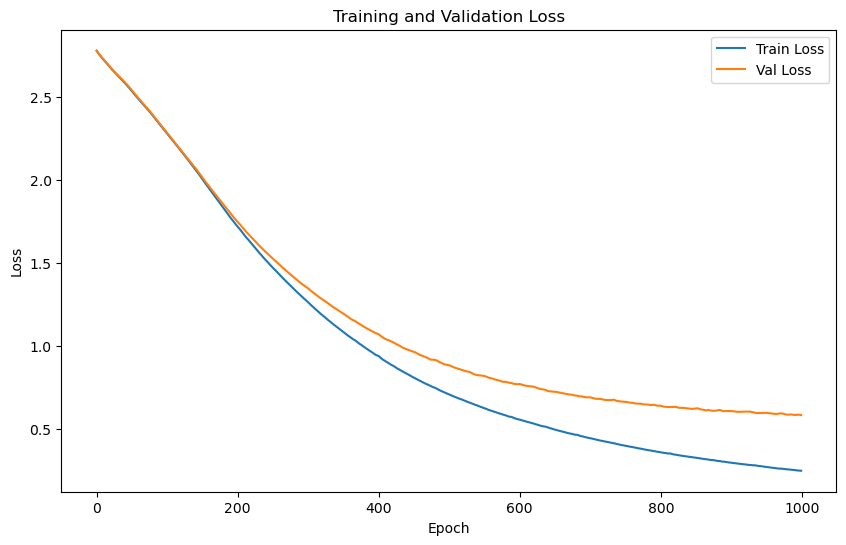

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7570 | Test Accuracy: 71.66%


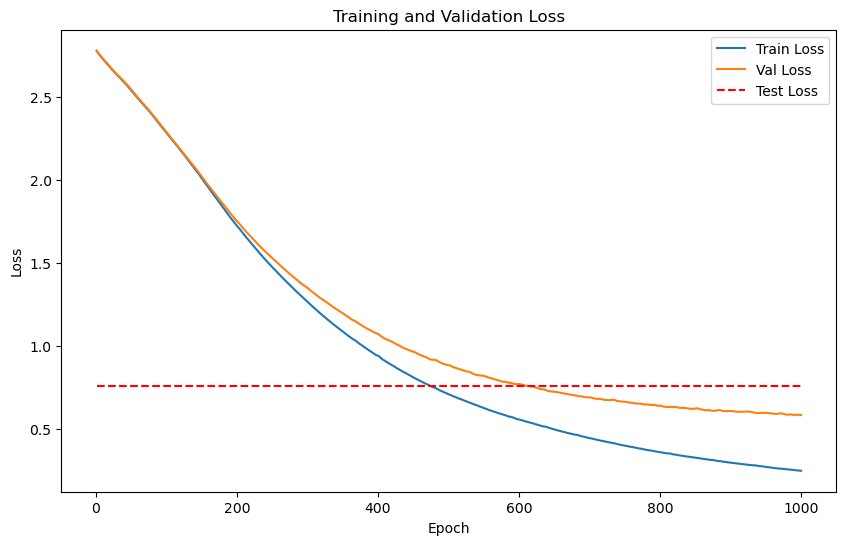

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3307
    Batch [2/2], Val Loss: 0.4215
Epoch [1/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3761

Validation loss improved from inf to 0.3761. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.4211
Epoch [2/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.4204
Epoch [3/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.3766

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.4197
Epoch [4/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.3770

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3355
    Batch [2/2], Val Loss: 0.4187
Epoch [5/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.4181
Epoch [6/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.4176
Epoch [7/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3365
    Batch [2/2], Val Loss: 0.4163
Epoch [8/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3764

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3369
    Batch [2/2], Val Loss: 0.4139
Epoch [9/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3754

Validation loss improved from 0.3761 to 0.3754. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.4106
Epoch [10/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3741

Validation loss improved from 0.3754 to 0.3741. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.4068
Epoch [11/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3725

Validation loss improved from 0.3741 to 0.3725. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.4026
Epoch [12/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3704

Validation loss improved from 0.3725 to 0.3704. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.3972
Epoch [13/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3676

Validation loss improved from 0.3704 to 0.3676. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.3915
Epoch [14/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3647

Validation loss improved from 0.3676 to 0.3647. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.3862
Epoch [15/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3619

Validation loss improved from 0.3647 to 0.3619. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.3819
Epoch [16/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3595

Validation loss improved from 0.3619 to 0.3595. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3364
    Batch [2/2], Val Loss: 0.3788
Epoch [17/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3576

Validation loss improved from 0.3595 to 0.3576. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3357
    Batch [2/2], Val Loss: 0.3763
Epoch [18/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3560

Validation loss improved from 0.3576 to 0.3560. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.3741
Epoch [19/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3543

Validation loss improved from 0.3560 to 0.3543. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.3722
Epoch [20/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3526

Validation loss improved from 0.3543 to 0.3526. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3316
    Batch [2/2], Val Loss: 0.3709
Epoch [21/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3512

Validation loss improved from 0.3526 to 0.3512. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.3694
Epoch [22/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3499

Validation loss improved from 0.3512 to 0.3499. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.3684
Epoch [23/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3489

Validation loss improved from 0.3499 to 0.3489. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3287
    Batch [2/2], Val Loss: 0.3674
Epoch [24/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3481

Validation loss improved from 0.3489 to 0.3481. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3281
    Batch [2/2], Val Loss: 0.3669
Epoch [25/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3475

Validation loss improved from 0.3481 to 0.3475. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3275
    Batch [2/2], Val Loss: 0.3665
Epoch [26/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3470

Validation loss improved from 0.3475 to 0.3470. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.3662
Epoch [27/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3466

Validation loss improved from 0.3470 to 0.3466. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3266
    Batch [2/2], Val Loss: 0.3661
Epoch [28/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3463

Validation loss improved from 0.3466 to 0.3463. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3262
    Batch [2/2], Val Loss: 0.3662
Epoch [29/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3462

Validation loss improved from 0.3463 to 0.3462. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3258
    Batch [2/2], Val Loss: 0.3664
Epoch [30/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3255
    Batch [2/2], Val Loss: 0.3665
Epoch [31/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3460

Validation loss improved from 0.3461 to 0.3460. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3251
    Batch [2/2], Val Loss: 0.3664
Epoch [32/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3458

Validation loss improved from 0.3460 to 0.3458. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3248
    Batch [2/2], Val Loss: 0.3662
Epoch [33/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3455

Validation loss improved from 0.3458 to 0.3455. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3244
    Batch [2/2], Val Loss: 0.3661
Epoch [34/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.3453

Validation loss improved from 0.3455 to 0.3453. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3241
    Batch [2/2], Val Loss: 0.3658
Epoch [35/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3450

Validation loss improved from 0.3453 to 0.3450. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3237
    Batch [2/2], Val Loss: 0.3656
Epoch [36/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3447

Validation loss improved from 0.3450 to 0.3447. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3234
    Batch [2/2], Val Loss: 0.3653
Epoch [37/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.3443

Validation loss improved from 0.3447 to 0.3443. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3230
    Batch [2/2], Val Loss: 0.3650
Epoch [38/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3440

Validation loss improved from 0.3443 to 0.3440. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3227
    Batch [2/2], Val Loss: 0.3648
Epoch [39/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3437

Validation loss improved from 0.3440 to 0.3437. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3223
    Batch [2/2], Val Loss: 0.3646
Epoch [40/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3220
    Batch [2/2], Val Loss: 0.3643
Epoch [41/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3431

Validation loss improved from 0.3435 to 0.3431. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3216
    Batch [2/2], Val Loss: 0.3640
Epoch [42/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3428

Validation loss improved from 0.3431 to 0.3428. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.3637
Epoch [43/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3425

Validation loss improved from 0.3428 to 0.3425. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3210
    Batch [2/2], Val Loss: 0.3634
Epoch [44/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3422

Validation loss improved from 0.3425 to 0.3422. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.3630
Epoch [45/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3418

Validation loss improved from 0.3422 to 0.3418. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3202
    Batch [2/2], Val Loss: 0.3626
Epoch [46/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3414

Validation loss improved from 0.3418 to 0.3414. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3198
    Batch [2/2], Val Loss: 0.3622
Epoch [47/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3410

Validation loss improved from 0.3414 to 0.3410. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3195
    Batch [2/2], Val Loss: 0.3619
Epoch [48/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3407

Validation loss improved from 0.3410 to 0.3407. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.3615
Epoch [49/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3403

Validation loss improved from 0.3407 to 0.3403. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3187
    Batch [2/2], Val Loss: 0.3611
Epoch [50/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3399

Validation loss improved from 0.3403 to 0.3399. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.3608
Epoch [51/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3395

Validation loss improved from 0.3399 to 0.3395. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3179
    Batch [2/2], Val Loss: 0.3605
Epoch [52/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.3602
Epoch [53/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3388

Validation loss improved from 0.3392 to 0.3388. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.3599
Epoch [54/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.3385

Validation loss improved from 0.3388 to 0.3385. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.3595
Epoch [55/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3381

Validation loss improved from 0.3385 to 0.3381. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.3593
Epoch [56/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3378

Validation loss improved from 0.3381 to 0.3378. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3158
    Batch [2/2], Val Loss: 0.3590
Epoch [57/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3374

Validation loss improved from 0.3378 to 0.3374. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3154
    Batch [2/2], Val Loss: 0.3587
Epoch [58/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3371

Validation loss improved from 0.3374 to 0.3371. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3149
    Batch [2/2], Val Loss: 0.3584
Epoch [59/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3367

Validation loss improved from 0.3371 to 0.3367. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.3580
Epoch [60/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3362

Validation loss improved from 0.3367 to 0.3362. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3141
    Batch [2/2], Val Loss: 0.3576
Epoch [61/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3358

Validation loss improved from 0.3362 to 0.3358. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3136
    Batch [2/2], Val Loss: 0.3572
Epoch [62/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3354

Validation loss improved from 0.3358 to 0.3354. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.3569
Epoch [63/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.3350

Validation loss improved from 0.3354 to 0.3350. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.3566
Epoch [64/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3347

Validation loss improved from 0.3350 to 0.3347. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.3563
Epoch [65/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3343

Validation loss improved from 0.3347 to 0.3343. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.3560
Epoch [66/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.3339

Validation loss improved from 0.3343 to 0.3339. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.3558
Epoch [67/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3336

Validation loss improved from 0.3339 to 0.3336. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.3555
Epoch [68/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3332

Validation loss improved from 0.3336 to 0.3332. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.3553
Epoch [69/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3329

Validation loss improved from 0.3332 to 0.3329. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3100
    Batch [2/2], Val Loss: 0.3551
Epoch [70/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3325

Validation loss improved from 0.3329 to 0.3325. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.3549
Epoch [71/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3322

Validation loss improved from 0.3325 to 0.3322. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.3547
Epoch [72/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3319

Validation loss improved from 0.3322 to 0.3319. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3087
    Batch [2/2], Val Loss: 0.3546
Epoch [73/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3316

Validation loss improved from 0.3319 to 0.3316. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.3544
Epoch [74/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3313

Validation loss improved from 0.3316 to 0.3313. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3077
    Batch [2/2], Val Loss: 0.3542
Epoch [75/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3309

Validation loss improved from 0.3313 to 0.3309. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.3539
Epoch [76/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3306

Validation loss improved from 0.3309 to 0.3306. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.3537
Epoch [77/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3302

Validation loss improved from 0.3306 to 0.3302. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.3533
Epoch [78/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3298

Validation loss improved from 0.3302 to 0.3298. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.3530
Epoch [79/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3293

Validation loss improved from 0.3298 to 0.3293. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3051
    Batch [2/2], Val Loss: 0.3526
Epoch [80/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3289

Validation loss improved from 0.3293 to 0.3289. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.3523
Epoch [81/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3284

Validation loss improved from 0.3289 to 0.3284. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.3519
Epoch [82/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3280

Validation loss improved from 0.3284 to 0.3280. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.3514
Epoch [83/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3275

Validation loss improved from 0.3280 to 0.3275. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.3510
Epoch [84/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3270

Validation loss improved from 0.3275 to 0.3270. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.3504
Epoch [85/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3265

Validation loss improved from 0.3270 to 0.3265. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3020
    Batch [2/2], Val Loss: 0.3499
Epoch [86/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3260

Validation loss improved from 0.3265 to 0.3260. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.3494
Epoch [87/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3255

Validation loss improved from 0.3260 to 0.3255. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3010
    Batch [2/2], Val Loss: 0.3488
Epoch [88/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3249

Validation loss improved from 0.3255 to 0.3249. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.3482
Epoch [89/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3001
    Batch [2/2], Val Loss: 0.3476
Epoch [90/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2996
    Batch [2/2], Val Loss: 0.3469
Epoch [91/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3233

Validation loss improved from 0.3238 to 0.3233. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2991
    Batch [2/2], Val Loss: 0.3463
Epoch [92/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3227

Validation loss improved from 0.3233 to 0.3227. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2986
    Batch [2/2], Val Loss: 0.3457
Epoch [93/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.3222

Validation loss improved from 0.3227 to 0.3222. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.3452
Epoch [94/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3217

Validation loss improved from 0.3222 to 0.3217. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2976
    Batch [2/2], Val Loss: 0.3447
Epoch [95/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3212

Validation loss improved from 0.3217 to 0.3212. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.3442
Epoch [96/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3207

Validation loss improved from 0.3212 to 0.3207. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.3437
Epoch [97/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3202

Validation loss improved from 0.3207 to 0.3202. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2962
    Batch [2/2], Val Loss: 0.3432
Epoch [98/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3197

Validation loss improved from 0.3202 to 0.3197. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2958
    Batch [2/2], Val Loss: 0.3427
Epoch [99/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.3193

Validation loss improved from 0.3197 to 0.3193. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.3423
Epoch [100/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.3188

Validation loss improved from 0.3193 to 0.3188. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2949
    Batch [2/2], Val Loss: 0.3420
Epoch [101/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3184

Validation loss improved from 0.3188 to 0.3184. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.3415
Epoch [102/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3180

Validation loss improved from 0.3184 to 0.3180. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2940
    Batch [2/2], Val Loss: 0.3410
Epoch [103/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.3175

Validation loss improved from 0.3180 to 0.3175. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2936
    Batch [2/2], Val Loss: 0.3406
Epoch [104/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3171

Validation loss improved from 0.3175 to 0.3171. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2932
    Batch [2/2], Val Loss: 0.3403
Epoch [105/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.3167

Validation loss improved from 0.3171 to 0.3167. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2928
    Batch [2/2], Val Loss: 0.3400
Epoch [106/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3164

Validation loss improved from 0.3167 to 0.3164. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.3397
Epoch [107/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3160

Validation loss improved from 0.3164 to 0.3160. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.3395
Epoch [108/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3157

Validation loss improved from 0.3160 to 0.3157. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.3392
Epoch [109/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3154

Validation loss improved from 0.3157 to 0.3154. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2911
    Batch [2/2], Val Loss: 0.3390
Epoch [110/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3151

Validation loss improved from 0.3154 to 0.3151. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2906
    Batch [2/2], Val Loss: 0.3389
Epoch [111/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3148

Validation loss improved from 0.3151 to 0.3148. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2902
    Batch [2/2], Val Loss: 0.3387
Epoch [112/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3145

Validation loss improved from 0.3148 to 0.3145. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2898
    Batch [2/2], Val Loss: 0.3386
Epoch [113/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3142

Validation loss improved from 0.3145 to 0.3142. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.3383
Epoch [114/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3138

Validation loss improved from 0.3142 to 0.3138. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.3380
Epoch [115/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.3135

Validation loss improved from 0.3138 to 0.3135. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.3378
Epoch [116/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3132

Validation loss improved from 0.3135 to 0.3132. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.3376
Epoch [117/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3129

Validation loss improved from 0.3132 to 0.3129. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2878
    Batch [2/2], Val Loss: 0.3375
Epoch [118/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.3126

Validation loss improved from 0.3129 to 0.3126. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2874
    Batch [2/2], Val Loss: 0.3373
Epoch [119/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3123

Validation loss improved from 0.3126 to 0.3123. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2870
    Batch [2/2], Val Loss: 0.3371
Epoch [120/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.3121

Validation loss improved from 0.3123 to 0.3121. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2866
    Batch [2/2], Val Loss: 0.3369
Epoch [121/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3118

Validation loss improved from 0.3121 to 0.3118. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.3367
Epoch [122/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3115

Validation loss improved from 0.3118 to 0.3115. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2860
    Batch [2/2], Val Loss: 0.3365
Epoch [123/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3113

Validation loss improved from 0.3115 to 0.3113. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.3364
Epoch [124/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.3111

Validation loss improved from 0.3113 to 0.3111. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.3363
Epoch [125/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3109

Validation loss improved from 0.3111 to 0.3109. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2851
    Batch [2/2], Val Loss: 0.3363
Epoch [126/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3107

Validation loss improved from 0.3109 to 0.3107. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.3362
Epoch [127/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3105

Validation loss improved from 0.3107 to 0.3105. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2846
    Batch [2/2], Val Loss: 0.3361
Epoch [128/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3103

Validation loss improved from 0.3105 to 0.3103. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.3359
Epoch [129/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3101

Validation loss improved from 0.3103 to 0.3101. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2841
    Batch [2/2], Val Loss: 0.3358
Epoch [130/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3099

Validation loss improved from 0.3101 to 0.3099. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2838
    Batch [2/2], Val Loss: 0.3357
Epoch [131/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3097

Validation loss improved from 0.3099 to 0.3097. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.3354
Epoch [132/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3094

Validation loss improved from 0.3097 to 0.3094. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2831
    Batch [2/2], Val Loss: 0.3352
Epoch [133/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3091

Validation loss improved from 0.3094 to 0.3091. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.3349
Epoch [134/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3088

Validation loss improved from 0.3091 to 0.3088. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.3347
Epoch [135/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3086

Validation loss improved from 0.3088 to 0.3086. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2821
    Batch [2/2], Val Loss: 0.3345
Epoch [136/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3083

Validation loss improved from 0.3086 to 0.3083. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2818
    Batch [2/2], Val Loss: 0.3343
Epoch [137/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3081

Validation loss improved from 0.3083 to 0.3081. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.3342
Epoch [138/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3078

Validation loss improved from 0.3081 to 0.3078. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.3340
Epoch [139/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3076

Validation loss improved from 0.3078 to 0.3076. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2809
    Batch [2/2], Val Loss: 0.3338
Epoch [140/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3073

Validation loss improved from 0.3076 to 0.3073. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.3336
Epoch [141/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3071

Validation loss improved from 0.3073 to 0.3071. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2803
    Batch [2/2], Val Loss: 0.3334
Epoch [142/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3069

Validation loss improved from 0.3071 to 0.3069. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.3332
Epoch [143/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3066

Validation loss improved from 0.3069 to 0.3066. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2797
    Batch [2/2], Val Loss: 0.3330
Epoch [144/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3064

Validation loss improved from 0.3066 to 0.3064. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2795
    Batch [2/2], Val Loss: 0.3328
Epoch [145/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3061

Validation loss improved from 0.3064 to 0.3061. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2792
    Batch [2/2], Val Loss: 0.3325
Epoch [146/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3058

Validation loss improved from 0.3061 to 0.3058. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2789
    Batch [2/2], Val Loss: 0.3321
Epoch [147/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.3055

Validation loss improved from 0.3058 to 0.3055. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.3318
Epoch [148/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3052

Validation loss improved from 0.3055 to 0.3052. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.3315
Epoch [149/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3049

Validation loss improved from 0.3052 to 0.3049. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.3311
Epoch [150/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.3046

Validation loss improved from 0.3049 to 0.3046. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.3308
Epoch [151/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.3043

Validation loss improved from 0.3046 to 0.3043. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.3305
Epoch [152/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3040

Validation loss improved from 0.3043 to 0.3040. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2772
    Batch [2/2], Val Loss: 0.3302
Epoch [153/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3037

Validation loss improved from 0.3040 to 0.3037. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.3299
Epoch [154/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3034

Validation loss improved from 0.3037 to 0.3034. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2767
    Batch [2/2], Val Loss: 0.3296
Epoch [155/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3031

Validation loss improved from 0.3034 to 0.3031. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.3292
Epoch [156/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3028

Validation loss improved from 0.3031 to 0.3028. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2762
    Batch [2/2], Val Loss: 0.3289
Epoch [157/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3026

Validation loss improved from 0.3028 to 0.3026. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.3286
Epoch [158/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3023

Validation loss improved from 0.3026 to 0.3023. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2757
    Batch [2/2], Val Loss: 0.3283
Epoch [159/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3020

Validation loss improved from 0.3023 to 0.3020. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.3281
Epoch [160/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3018

Validation loss improved from 0.3020 to 0.3018. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2753
    Batch [2/2], Val Loss: 0.3279
Epoch [161/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3016

Validation loss improved from 0.3018 to 0.3016. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.3277
Epoch [162/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3014

Validation loss improved from 0.3016 to 0.3014. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.3276
Epoch [163/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3012

Validation loss improved from 0.3014 to 0.3012. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2745
    Batch [2/2], Val Loss: 0.3274
Epoch [164/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.3010

Validation loss improved from 0.3012 to 0.3010. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2743
    Batch [2/2], Val Loss: 0.3273
Epoch [165/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.3008

Validation loss improved from 0.3010 to 0.3008. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.3272
Epoch [166/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.3006

Validation loss improved from 0.3008 to 0.3006. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.3272
Epoch [167/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.3271
Epoch [168/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3003

Validation loss improved from 0.3005 to 0.3003. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.3270
Epoch [169/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3002

Validation loss improved from 0.3003 to 0.3002. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.3269
Epoch [170/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3000

Validation loss improved from 0.3002 to 0.3000. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2728
    Batch [2/2], Val Loss: 0.3267
Epoch [171/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2998

Validation loss improved from 0.3000 to 0.2998. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2725
    Batch [2/2], Val Loss: 0.3266
Epoch [172/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2996

Validation loss improved from 0.2998 to 0.2996. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2722
    Batch [2/2], Val Loss: 0.3265
Epoch [173/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2993

Validation loss improved from 0.2996 to 0.2993. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.3263
Epoch [174/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2991

Validation loss improved from 0.2993 to 0.2991. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.3261
Epoch [175/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2989

Validation loss improved from 0.2991 to 0.2989. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2714
    Batch [2/2], Val Loss: 0.3259
Epoch [176/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2987

Validation loss improved from 0.2989 to 0.2987. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2711
    Batch [2/2], Val Loss: 0.3258
Epoch [177/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2984

Validation loss improved from 0.2987 to 0.2984. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.3257
Epoch [178/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2982

Validation loss improved from 0.2984 to 0.2982. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.3256
Epoch [179/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2980

Validation loss improved from 0.2982 to 0.2980. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.3254
Epoch [180/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2978

Validation loss improved from 0.2980 to 0.2978. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.3253
Epoch [181/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.2976

Validation loss improved from 0.2978 to 0.2976. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2697
    Batch [2/2], Val Loss: 0.3251
Epoch [182/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2974

Validation loss improved from 0.2976 to 0.2974. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.3249
Epoch [183/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2971

Validation loss improved from 0.2974 to 0.2971. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.3246
Epoch [184/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.3243
Epoch [185/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2966

Validation loss improved from 0.2969 to 0.2966. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.3240
Epoch [186/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2963

Validation loss improved from 0.2966 to 0.2963. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2685
    Batch [2/2], Val Loss: 0.3236
Epoch [187/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2960

Validation loss improved from 0.2963 to 0.2960. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.3231
Epoch [188/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2957

Validation loss improved from 0.2960 to 0.2957. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.3227
Epoch [189/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2954

Validation loss improved from 0.2957 to 0.2954. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.3223
Epoch [190/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2951

Validation loss improved from 0.2954 to 0.2951. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2676
    Batch [2/2], Val Loss: 0.3219
Epoch [191/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2947

Validation loss improved from 0.2951 to 0.2947. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.3214
Epoch [192/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2944

Validation loss improved from 0.2947 to 0.2944. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.3211
Epoch [193/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2941

Validation loss improved from 0.2944 to 0.2941. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2669
    Batch [2/2], Val Loss: 0.3208
Epoch [194/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2938

Validation loss improved from 0.2941 to 0.2938. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2667
    Batch [2/2], Val Loss: 0.3205
Epoch [195/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2936

Validation loss improved from 0.2938 to 0.2936. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.3203
Epoch [196/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2934

Validation loss improved from 0.2936 to 0.2934. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.3201
Epoch [197/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2932

Validation loss improved from 0.2934 to 0.2932. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2661
    Batch [2/2], Val Loss: 0.3199
Epoch [198/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2930

Validation loss improved from 0.2932 to 0.2930. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.3198
Epoch [199/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2928

Validation loss improved from 0.2930 to 0.2928. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2657
    Batch [2/2], Val Loss: 0.3197
Epoch [200/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2927

Validation loss improved from 0.2928 to 0.2927. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.3195
Epoch [201/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2925

Validation loss improved from 0.2927 to 0.2925. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2653
    Batch [2/2], Val Loss: 0.3194
Epoch [202/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2924

Validation loss improved from 0.2925 to 0.2924. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2651
    Batch [2/2], Val Loss: 0.3193
Epoch [203/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2922

Validation loss improved from 0.2924 to 0.2922. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.3191
Epoch [204/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2920

Validation loss improved from 0.2922 to 0.2920. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.3190
Epoch [205/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2919

Validation loss improved from 0.2920 to 0.2919. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2645
    Batch [2/2], Val Loss: 0.3188
Epoch [206/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2917

Validation loss improved from 0.2919 to 0.2917. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.3188
Epoch [207/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2916

Validation loss improved from 0.2917 to 0.2916. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2641
    Batch [2/2], Val Loss: 0.3189
Epoch [208/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2915

Validation loss improved from 0.2916 to 0.2915. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2639
    Batch [2/2], Val Loss: 0.3189
Epoch [209/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2914

Validation loss improved from 0.2915 to 0.2914. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2637
    Batch [2/2], Val Loss: 0.3189
Epoch [210/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2913

Validation loss improved from 0.2914 to 0.2913. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.3188
Epoch [211/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2911

Validation loss improved from 0.2913 to 0.2911. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2632
    Batch [2/2], Val Loss: 0.3187
Epoch [212/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2910

Validation loss improved from 0.2911 to 0.2910. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2630
    Batch [2/2], Val Loss: 0.3186
Epoch [213/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2908

Validation loss improved from 0.2910 to 0.2908. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.3184
Epoch [214/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2906

Validation loss improved from 0.2908 to 0.2906. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2626
    Batch [2/2], Val Loss: 0.3182
Epoch [215/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2904

Validation loss improved from 0.2906 to 0.2904. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.3181
Epoch [216/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2902

Validation loss improved from 0.2904 to 0.2902. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.3180
Epoch [217/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2901

Validation loss improved from 0.2902 to 0.2901. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.3178
Epoch [218/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2899

Validation loss improved from 0.2901 to 0.2899. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.3176
Epoch [219/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2897

Validation loss improved from 0.2899 to 0.2897. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.3175
Epoch [220/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2895

Validation loss improved from 0.2897 to 0.2895. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3060
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2614
    Batch [2/2], Val Loss: 0.3173
Epoch [221/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2893

Validation loss improved from 0.2895 to 0.2893. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.3172
Epoch [222/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.2892

Validation loss improved from 0.2893 to 0.2892. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2610
    Batch [2/2], Val Loss: 0.3170
Epoch [223/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2890

Validation loss improved from 0.2892 to 0.2890. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.3169
Epoch [224/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2888

Validation loss improved from 0.2890 to 0.2888. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3168
Epoch [225/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.2887

Validation loss improved from 0.2888 to 0.2887. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.3167
Epoch [226/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2885

Validation loss improved from 0.2887 to 0.2885. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.3167
Epoch [227/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2883

Validation loss improved from 0.2885 to 0.2883. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.3166
Epoch [228/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2882

Validation loss improved from 0.2883 to 0.2882. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2596
    Batch [2/2], Val Loss: 0.3164
Epoch [229/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2880

Validation loss improved from 0.2882 to 0.2880. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.3163
Epoch [230/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.2878

Validation loss improved from 0.2880 to 0.2878. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2591
    Batch [2/2], Val Loss: 0.3162
Epoch [231/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2876

Validation loss improved from 0.2878 to 0.2876. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.3161
Epoch [232/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.2875

Validation loss improved from 0.2876 to 0.2875. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.3160
Epoch [233/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2874

Validation loss improved from 0.2875 to 0.2874. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2585
    Batch [2/2], Val Loss: 0.3160
Epoch [234/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2872

Validation loss improved from 0.2874 to 0.2872. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.3160
Epoch [235/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2872

Validation loss improved from 0.2872 to 0.2872. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.3159
Epoch [236/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2870

Validation loss improved from 0.2872 to 0.2870. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2580
    Batch [2/2], Val Loss: 0.3158
Epoch [237/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2869

Validation loss improved from 0.2870 to 0.2869. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.3158
Epoch [238/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2868

Validation loss improved from 0.2869 to 0.2868. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2992
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2577
    Batch [2/2], Val Loss: 0.3157
Epoch [239/2000], Avg Train Loss: 0.2992, Avg Val Loss: 0.2867

Validation loss improved from 0.2868 to 0.2867. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.3157
Epoch [240/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.2866

Validation loss improved from 0.2867 to 0.2866. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.3157
Epoch [241/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2865

Validation loss improved from 0.2866 to 0.2865. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2571
    Batch [2/2], Val Loss: 0.3157
Epoch [242/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2864

Validation loss improved from 0.2865 to 0.2864. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2569
    Batch [2/2], Val Loss: 0.3158
Epoch [243/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.2863

Validation loss improved from 0.2864 to 0.2863. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.3158
Epoch [244/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2863

Validation loss improved from 0.2863 to 0.2863. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.3159
Epoch [245/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2862

Validation loss improved from 0.2863 to 0.2862. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.3159
Epoch [246/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.3160
Epoch [247/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2860

Validation loss improved from 0.2861 to 0.2860. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.3159
Epoch [248/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2859

Validation loss improved from 0.2860 to 0.2859. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.3159
Epoch [249/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2987
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.3159
Epoch [250/2000], Avg Train Loss: 0.2987, Avg Val Loss: 0.2856

Validation loss improved from 0.2858 to 0.2856. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.3158
Epoch [251/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2855

Validation loss improved from 0.2856 to 0.2855. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.3159
Epoch [252/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.3159
Epoch [253/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.3160
Epoch [254/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.3161
Epoch [255/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2852

Validation loss improved from 0.2853 to 0.2852. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.3163
Epoch [256/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.3164
Epoch [257/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3165
Epoch [258/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2851

Validation loss improved from 0.2852 to 0.2851. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.3165
Epoch [259/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2850

Validation loss improved from 0.2851 to 0.2850. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.3166
Epoch [260/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2850

Validation loss improved from 0.2850 to 0.2850. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.3167
Epoch [261/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2849

Validation loss improved from 0.2850 to 0.2849. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.3168
Epoch [262/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2849

Validation loss improved from 0.2849 to 0.2849. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.3168
Epoch [263/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2849

Validation loss improved from 0.2849 to 0.2849. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.3168
Epoch [264/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2848

Validation loss improved from 0.2849 to 0.2848. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2526
    Batch [2/2], Val Loss: 0.3168
Epoch [265/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2524
    Batch [2/2], Val Loss: 0.3169
Epoch [266/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2847

Validation loss improved from 0.2847 to 0.2847. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.3170
Epoch [267/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2846

Validation loss improved from 0.2847 to 0.2846. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.3171
Epoch [268/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2846

Validation loss improved from 0.2846 to 0.2846. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.3171
Epoch [269/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2845

Validation loss improved from 0.2846 to 0.2845. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.3172
Epoch [270/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.3172
Epoch [271/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2843

Validation loss improved from 0.2844 to 0.2843. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3171
Epoch [272/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2842

Validation loss improved from 0.2843 to 0.2842. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.3171
Epoch [273/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.2841

Validation loss improved from 0.2842 to 0.2841. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.3170
Epoch [274/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.3170
Epoch [275/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2839

Validation loss improved from 0.2840 to 0.2839. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.3169
Epoch [276/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2838

Validation loss improved from 0.2839 to 0.2838. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.3168
Epoch [277/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.3168
Epoch [278/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2836

Validation loss improved from 0.2837 to 0.2836. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.3169
Epoch [279/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2501
    Batch [2/2], Val Loss: 0.3170
Epoch [280/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2836

Validation loss improved from 0.2836 to 0.2836. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2500
    Batch [2/2], Val Loss: 0.3172
Epoch [281/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.3176
Epoch [282/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2837

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.3179
Epoch [283/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2838

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2872
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.3182
Epoch [284/2000], Avg Train Loss: 0.2872, Avg Val Loss: 0.2838

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2493
    Batch [2/2], Val Loss: 0.3184
Epoch [285/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2839

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.3185
Epoch [286/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2839

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2490
    Batch [2/2], Val Loss: 0.3187
Epoch [287/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2838

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.3188
Epoch [288/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2838

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2487
    Batch [2/2], Val Loss: 0.3188
Epoch [289/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2837

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.3188
Epoch [290/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.3187
Epoch [291/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.2835

Validation loss improved from 0.2836 to 0.2835. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2480
    Batch [2/2], Val Loss: 0.3187
Epoch [292/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2834

Validation loss improved from 0.2835 to 0.2834. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.3186
Epoch [293/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.3186
Epoch [294/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2831

Validation loss improved from 0.2832 to 0.2831. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.3186
Epoch [295/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2830

Validation loss improved from 0.2831 to 0.2830. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2473
    Batch [2/2], Val Loss: 0.3185
Epoch [296/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2829

Validation loss improved from 0.2830 to 0.2829. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2717
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2471
    Batch [2/2], Val Loss: 0.3184
Epoch [297/2000], Avg Train Loss: 0.2717, Avg Val Loss: 0.2828

Validation loss improved from 0.2829 to 0.2828. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2470
    Batch [2/2], Val Loss: 0.3182
Epoch [298/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2468
    Batch [2/2], Val Loss: 0.3179
Epoch [299/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.3176
Epoch [300/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.2821

Validation loss improved from 0.2824 to 0.2821. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2465
    Batch [2/2], Val Loss: 0.3173
Epoch [301/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2819

Validation loss improved from 0.2821 to 0.2819. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2463
    Batch [2/2], Val Loss: 0.3171
Epoch [302/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2817

Validation loss improved from 0.2819 to 0.2817. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2462
    Batch [2/2], Val Loss: 0.3169
Epoch [303/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2815

Validation loss improved from 0.2817 to 0.2815. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2461
    Batch [2/2], Val Loss: 0.3167
Epoch [304/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2814

Validation loss improved from 0.2815 to 0.2814. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.3165
Epoch [305/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2812

Validation loss improved from 0.2814 to 0.2812. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2458
    Batch [2/2], Val Loss: 0.3165
Epoch [306/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2811

Validation loss improved from 0.2812 to 0.2811. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2457
    Batch [2/2], Val Loss: 0.3163
Epoch [307/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2810

Validation loss improved from 0.2811 to 0.2810. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.3163
Epoch [308/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2809

Validation loss improved from 0.2810 to 0.2809. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2453
    Batch [2/2], Val Loss: 0.3163
Epoch [309/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2808

Validation loss improved from 0.2809 to 0.2808. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2452
    Batch [2/2], Val Loss: 0.3162
Epoch [310/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2807

Validation loss improved from 0.2808 to 0.2807. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2450
    Batch [2/2], Val Loss: 0.3163
Epoch [311/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2806

Validation loss improved from 0.2807 to 0.2806. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.3162
Epoch [312/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2805

Validation loss improved from 0.2806 to 0.2805. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.3162
Epoch [313/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2804

Validation loss improved from 0.2805 to 0.2804. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2444
    Batch [2/2], Val Loss: 0.3161
Epoch [314/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2802

Validation loss improved from 0.2804 to 0.2802. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.3161
Epoch [315/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2801

Validation loss improved from 0.2802 to 0.2801. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.3160
Epoch [316/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2799

Validation loss improved from 0.2801 to 0.2799. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2437
    Batch [2/2], Val Loss: 0.3159
Epoch [317/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2798

Validation loss improved from 0.2799 to 0.2798. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2435
    Batch [2/2], Val Loss: 0.3159
Epoch [318/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.2797

Validation loss improved from 0.2798 to 0.2797. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2433
    Batch [2/2], Val Loss: 0.3158
Epoch [319/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2431
    Batch [2/2], Val Loss: 0.3157
Epoch [320/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2794

Validation loss improved from 0.2796 to 0.2794. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.3155
Epoch [321/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2793

Validation loss improved from 0.2794 to 0.2793. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2428
    Batch [2/2], Val Loss: 0.3154
Epoch [322/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2791

Validation loss improved from 0.2793 to 0.2791. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2427
    Batch [2/2], Val Loss: 0.3154
Epoch [323/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.3154
Epoch [324/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2790

Validation loss improved from 0.2790 to 0.2790. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2424
    Batch [2/2], Val Loss: 0.3153
Epoch [325/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2788

Validation loss improved from 0.2790 to 0.2788. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2422
    Batch [2/2], Val Loss: 0.3153
Epoch [326/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2788

Validation loss improved from 0.2788 to 0.2788. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2421
    Batch [2/2], Val Loss: 0.3152
Epoch [327/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2787

Validation loss improved from 0.2788 to 0.2787. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2420
    Batch [2/2], Val Loss: 0.3151
Epoch [328/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2785

Validation loss improved from 0.2787 to 0.2785. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.3151
Epoch [329/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2785

Validation loss improved from 0.2785 to 0.2785. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2418
    Batch [2/2], Val Loss: 0.3150
Epoch [330/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2784

Validation loss improved from 0.2785 to 0.2784. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2417
    Batch [2/2], Val Loss: 0.3151
Epoch [331/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2784

Validation loss improved from 0.2784 to 0.2784. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2415
    Batch [2/2], Val Loss: 0.3151
Epoch [332/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2783

Validation loss improved from 0.2784 to 0.2783. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2634
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2414
    Batch [2/2], Val Loss: 0.3152
Epoch [333/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.3153
Epoch [334/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2783

Validation loss improved from 0.2783 to 0.2783. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2412
    Batch [2/2], Val Loss: 0.3153
Epoch [335/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.2783

Validation loss improved from 0.2783 to 0.2783. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.3155
Epoch [336/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.3157
Epoch [337/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2408
    Batch [2/2], Val Loss: 0.3158
Epoch [338/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2406
    Batch [2/2], Val Loss: 0.3159
Epoch [339/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2405
    Batch [2/2], Val Loss: 0.3160
Epoch [340/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.2783

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.3160
Epoch [341/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.2782

Validation loss improved from 0.2783 to 0.2782. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2403
    Batch [2/2], Val Loss: 0.3160
Epoch [342/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2781

Validation loss improved from 0.2782 to 0.2781. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.3160
Epoch [343/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.2781

Validation loss improved from 0.2781 to 0.2781. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2400
    Batch [2/2], Val Loss: 0.3160
Epoch [344/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.2780

Validation loss improved from 0.2781 to 0.2780. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2399
    Batch [2/2], Val Loss: 0.3160
Epoch [345/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2779

Validation loss improved from 0.2780 to 0.2779. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.3160
Epoch [346/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.2779

Validation loss improved from 0.2779 to 0.2779. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2396
    Batch [2/2], Val Loss: 0.3160
Epoch [347/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2394
    Batch [2/2], Val Loss: 0.3159
Epoch [348/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2393
    Batch [2/2], Val Loss: 0.3159
Epoch [349/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.2776

Validation loss improved from 0.2777 to 0.2776. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.3159
Epoch [350/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2391
    Batch [2/2], Val Loss: 0.3160
Epoch [351/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2390
    Batch [2/2], Val Loss: 0.3160
Epoch [352/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2389
    Batch [2/2], Val Loss: 0.3160
Epoch [353/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.3160
Epoch [354/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2774

Validation loss improved from 0.2774 to 0.2774. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2386
    Batch [2/2], Val Loss: 0.3159
Epoch [355/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.3158
Epoch [356/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.2771

Validation loss improved from 0.2773 to 0.2771. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.3156
Epoch [357/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2381
    Batch [2/2], Val Loss: 0.3154
Epoch [358/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2768

Validation loss improved from 0.2769 to 0.2768. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2379
    Batch [2/2], Val Loss: 0.3153
Epoch [359/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.3153
Epoch [360/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2765

Validation loss improved from 0.2766 to 0.2765. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.3155
Epoch [361/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.3156
Epoch [362/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2372
    Batch [2/2], Val Loss: 0.3157
Epoch [363/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2764

Validation loss improved from 0.2765 to 0.2764. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.3157
Epoch [364/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2764

Validation loss improved from 0.2764 to 0.2764. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.3158
Epoch [365/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.2763

Validation loss improved from 0.2764 to 0.2763. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.3158
Epoch [366/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2762

Validation loss improved from 0.2763 to 0.2762. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.3159
Epoch [367/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2762

Validation loss improved from 0.2762 to 0.2762. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.3159
Epoch [368/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2361
    Batch [2/2], Val Loss: 0.3159
Epoch [369/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2760

Validation loss improved from 0.2761 to 0.2760. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2360
    Batch [2/2], Val Loss: 0.3158
Epoch [370/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.2759

Validation loss improved from 0.2760 to 0.2759. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.3157
Epoch [371/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2758

Validation loss improved from 0.2759 to 0.2758. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2357
    Batch [2/2], Val Loss: 0.3156
Epoch [372/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2757

Validation loss improved from 0.2758 to 0.2757. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2356
    Batch [2/2], Val Loss: 0.3154
Epoch [373/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2755

Validation loss improved from 0.2757 to 0.2755. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2355
    Batch [2/2], Val Loss: 0.3152
Epoch [374/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2754

Validation loss improved from 0.2755 to 0.2754. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2354
    Batch [2/2], Val Loss: 0.3150
Epoch [375/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2353
    Batch [2/2], Val Loss: 0.3149
Epoch [376/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.2751

Validation loss improved from 0.2752 to 0.2751. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.3149
Epoch [377/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2750

Validation loss improved from 0.2751 to 0.2750. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.3149
Epoch [378/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2750

Validation loss improved from 0.2750 to 0.2750. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2351
    Batch [2/2], Val Loss: 0.3150
Epoch [379/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2751

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2350
    Batch [2/2], Val Loss: 0.3150
Epoch [380/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.2750

Validation loss improved from 0.2750 to 0.2750. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2349
    Batch [2/2], Val Loss: 0.3149
Epoch [381/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.3148
Epoch [382/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.2748

Validation loss improved from 0.2749 to 0.2748. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2347
    Batch [2/2], Val Loss: 0.3148
Epoch [383/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2345
    Batch [2/2], Val Loss: 0.3148
Epoch [384/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.3148
Epoch [385/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2448
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2342
    Batch [2/2], Val Loss: 0.3148
Epoch [386/2000], Avg Train Loss: 0.2448, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.3149
Epoch [387/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.2745

Validation loss improved from 0.2745 to 0.2745. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.3149
Epoch [388/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2339
    Batch [2/2], Val Loss: 0.3149
Epoch [389/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2338
    Batch [2/2], Val Loss: 0.3150
Epoch [390/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2744

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.3151
Epoch [391/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.3150
Epoch [392/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2334
    Batch [2/2], Val Loss: 0.3149
Epoch [393/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2333
    Batch [2/2], Val Loss: 0.3147
Epoch [394/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2331
    Batch [2/2], Val Loss: 0.3145
Epoch [395/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2330
    Batch [2/2], Val Loss: 0.3143
Epoch [396/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2329
    Batch [2/2], Val Loss: 0.3140
Epoch [397/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.3136
Epoch [398/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.3133
Epoch [399/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.3130
Epoch [400/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.3128
Epoch [401/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.3128
Epoch [402/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.3128
Epoch [403/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.3128
Epoch [404/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.3129
Epoch [405/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.3129
Epoch [406/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2314
    Batch [2/2], Val Loss: 0.3130
Epoch [407/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.3131
Epoch [408/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.3131
Epoch [409/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2307
    Batch [2/2], Val Loss: 0.3132
Epoch [410/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.3132
Epoch [411/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.3133
Epoch [412/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2301
    Batch [2/2], Val Loss: 0.3135
Epoch [413/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.3137
Epoch [414/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2298
    Batch [2/2], Val Loss: 0.3140
Epoch [415/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.2719

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.3143
Epoch [416/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.3147
Epoch [417/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.3150
Epoch [418/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.3153
Epoch [419/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2724

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.3155
Epoch [420/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.3157
Epoch [421/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.3159
Epoch [422/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.3162
Epoch [423/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.3164
Epoch [424/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.3166
Epoch [425/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.3167
Epoch [426/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.3169
Epoch [427/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.3171
Epoch [428/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.3171
Epoch [429/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.3172
Epoch [430/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.3171
Epoch [431/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.3172
Epoch [432/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.3173
Epoch [433/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.3173
Epoch [434/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.3173
Epoch [435/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.3174
Epoch [436/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.3173
Epoch [437/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.3173
Epoch [438/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.3172
Epoch [439/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.3170
Epoch [440/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.3169
Epoch [441/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2724

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.3168
Epoch [442/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3167
Epoch [443/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3165
Epoch [444/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3164
Epoch [445/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3164
Epoch [446/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3163
Epoch [447/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3162
Epoch [448/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3161
Epoch [449/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2719

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3160
Epoch [450/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2719

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.3160
Epoch [451/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2719

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3159
Epoch [452/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2718

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3158
Epoch [453/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3158
Epoch [454/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3157
Epoch [455/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3156
Epoch [456/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3156
Epoch [457/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3155
Epoch [458/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3155
Epoch [459/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3154
Epoch [460/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3154
Epoch [461/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3154
Epoch [462/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3154
Epoch [463/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3154
Epoch [464/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3153
Epoch [465/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3153
Epoch [466/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3153
Epoch [467/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3152
Epoch [468/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2714

Validation loss improved from 0.2714 to 0.2714. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3152
Epoch [469/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2714

Validation loss improved from 0.2714 to 0.2714. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3152
Epoch [470/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2714

Validation loss improved from 0.2714 to 0.2714. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.3151
Epoch [471/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3151
Epoch [472/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3151
Epoch [473/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [474/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [475/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [476/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [477/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [478/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3150
Epoch [479/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3150
Epoch [480/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3150
Epoch [481/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3149
Epoch [482/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3149
Epoch [483/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2712

Validation loss improved from 0.2712 to 0.2712. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3149
Epoch [484/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3149
Epoch [485/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3148
Epoch [486/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [487/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [488/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [489/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [490/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [491/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [492/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [493/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.3148
Epoch [494/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [495/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2710

Validation loss improved from 0.2710 to 0.2710. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [496/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [497/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [498/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [499/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3148
Epoch [500/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [501/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [502/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [503/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2710

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [504/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [505/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3149
Epoch [506/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3150
Epoch [507/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3150
Epoch [508/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3150
Epoch [509/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [510/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [511/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [512/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [513/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [514/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3150
Epoch [515/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [516/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [517/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [518/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [519/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [520/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [521/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [522/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [523/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [524/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [525/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [526/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [527/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [528/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [529/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [530/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [531/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [532/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [533/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [534/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [535/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3151
Epoch [536/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [537/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [538/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [539/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [540/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [541/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [542/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [543/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [544/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [545/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [546/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [547/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [548/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [549/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2181
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [550/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2210
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [551/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [552/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [553/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [554/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [555/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [556/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [557/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [558/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [559/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [560/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [561/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [562/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [563/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [564/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [565/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [566/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [567/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [568/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2163
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [569/2000], Avg Train Loss: 0.2163, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [570/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [571/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [572/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [573/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [574/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [575/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [576/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [577/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [578/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [579/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [580/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [581/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [582/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [583/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [584/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [585/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [586/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [587/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [588/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [589/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [590/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [591/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [592/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [593/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [594/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3151
Epoch [595/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2711

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 595!!
No improvement for 100 epochs


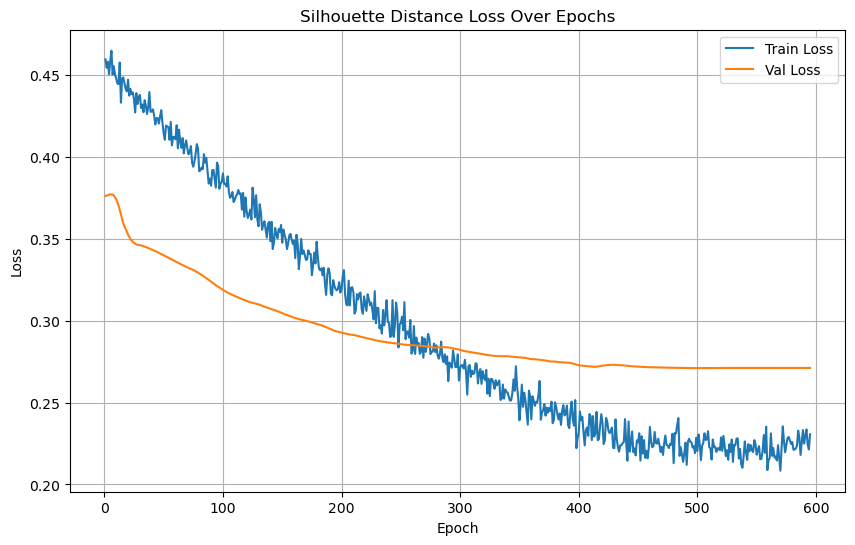

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/844], Loss: 0.0939


Test Batch [20/844], Loss: 0.1997
Test Batch [30/844], Loss: 0.2377
Test Batch [40/844], Loss: 0.1423
Test Batch [50/844], Loss: 0.1179
Test Batch [60/844], Loss: 0.5000
Test Batch [70/844], Loss: 0.1653


Test Batch [80/844], Loss: 0.2118


Test Batch [90/844], Loss: 0.5000
Test Batch [100/844], Loss: 0.2357
Test Batch [110/844], Loss: 0.1888
Test Batch [120/844], Loss: 0.1393
Test Batch [130/844], Loss: 0.5000
Test Batch [140/844], Loss: 0.1382
Test Batch [150/844], Loss: 0.1560


Test Batch [160/844], Loss: 0.2467
Test Batch [170/844], Loss: 0.2146
Test Batch [180/844], Loss: 0.1421
Test Batch [190/844], Loss: 0.1369
Test Batch [200/844], Loss: 0.1078


Test Batch [210/844], Loss: 0.1057
Test Batch [220/844], Loss: 0.0852
Test Batch [230/844], Loss: 0.1030
Test Batch [240/844], Loss: 0.1241
Test Batch [250/844], Loss: 0.1213


Test Batch [260/844], Loss: 0.3169
Test Batch [270/844], Loss: 0.2764
Test Batch [280/844], Loss: 0.2866
Test Batch [290/844], Loss: 0.2043
Test Batch [300/844], Loss: 0.2348


Test Batch [310/844], Loss: 0.1714
Test Batch [320/844], Loss: 0.1424
Test Batch [330/844], Loss: 0.2395
Test Batch [340/844], Loss: 0.2465
Test Batch [350/844], Loss: 0.5000
Test Batch [360/844], Loss: 0.1566
Test Batch [370/844], Loss: 0.5000
Test Batch [380/844], Loss: 0.5000
Test Batch [390/844], Loss: 0.5000


Test Batch [400/844], Loss: 0.5000
Test Batch [410/844], Loss: 0.5000
Test Batch [420/844], Loss: 0.5000
Test Batch [430/844], Loss: 0.1160
Test Batch [440/844], Loss: 0.1205
Test Batch [450/844], Loss: 0.1758
Test Batch [460/844], Loss: 0.1233
Test Batch [470/844], Loss: 0.1136


Test Batch [480/844], Loss: 0.1606
Test Batch [490/844], Loss: 0.5000
Test Batch [500/844], Loss: 0.1476
Test Batch [510/844], Loss: 0.1429
Test Batch [520/844], Loss: 0.0769
Test Batch [530/844], Loss: 0.0760
Test Batch [540/844], Loss: 0.1666


Test Batch [550/844], Loss: 0.0834
Test Batch [560/844], Loss: 0.0885
Test Batch [570/844], Loss: 0.1161
Test Batch [580/844], Loss: 0.2009
Test Batch [590/844], Loss: 0.1471
Test Batch [600/844], Loss: 0.0840


Test Batch [610/844], Loss: 0.1529
Test Batch [620/844], Loss: 0.1766
Test Batch [630/844], Loss: 0.3839
Test Batch [640/844], Loss: 0.1880
Test Batch [650/844], Loss: 0.0864


Test Batch [660/844], Loss: 0.0836
Test Batch [670/844], Loss: 0.1497
Test Batch [680/844], Loss: 0.1064
Test Batch [690/844], Loss: 0.0780
Test Batch [700/844], Loss: 0.3465
Test Batch [710/844], Loss: 0.1017


Test Batch [720/844], Loss: 0.3429
Test Batch [730/844], Loss: 0.0904
Test Batch [740/844], Loss: 0.1453
Test Batch [750/844], Loss: 0.1913
Test Batch [760/844], Loss: 0.1725


Test Batch [770/844], Loss: 0.5000
Test Batch [780/844], Loss: 0.1836
Test Batch [790/844], Loss: 0.1531
Test Batch [800/844], Loss: 0.3644
Test Batch [810/844], Loss: 0.1356
Test Batch [820/844], Loss: 0.1330
Test Batch [830/844], Loss: 0.1280


Test Batch [840/844], Loss: 0.1836

Test Loss: 0.2259


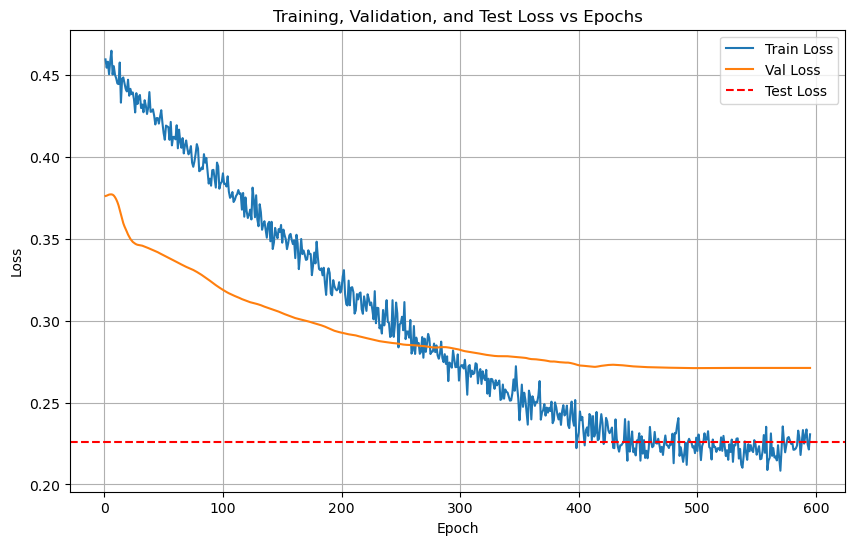

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/844 for test dataset.


  Processed batch 20/844 for test dataset.
  Processed batch 30/844 for test dataset.
  Processed batch 40/844 for test dataset.


  Processed batch 50/844 for test dataset.


  Processed batch 60/844 for test dataset.
  Processed batch 70/844 for test dataset.


  Processed batch 80/844 for test dataset.


  Processed batch 90/844 for test dataset.
  Processed batch 100/844 for test dataset.
  Processed batch 110/844 for test dataset.


  Processed batch 120/844 for test dataset.
  Processed batch 130/844 for test dataset.
  Processed batch 140/844 for test dataset.
  Processed batch 150/844 for test dataset.


  Processed batch 160/844 for test dataset.
  Processed batch 170/844 for test dataset.
  Processed batch 180/844 for test dataset.


  Processed batch 190/844 for test dataset.
  Processed batch 200/844 for test dataset.
  Processed batch 210/844 for test dataset.
  Processed batch 220/844 for test dataset.


  Processed batch 230/844 for test dataset.
  Processed batch 240/844 for test dataset.
  Processed batch 250/844 for test dataset.


  Processed batch 260/844 for test dataset.
  Processed batch 270/844 for test dataset.
  Processed batch 280/844 for test dataset.


  Processed batch 290/844 for test dataset.
  Processed batch 300/844 for test dataset.


  Processed batch 310/844 for test dataset.
  Processed batch 320/844 for test dataset.
  Processed batch 330/844 for test dataset.


  Processed batch 340/844 for test dataset.
  Processed batch 350/844 for test dataset.
  Processed batch 360/844 for test dataset.


  Processed batch 370/844 for test dataset.
  Processed batch 380/844 for test dataset.
  Processed batch 390/844 for test dataset.
  Processed batch 400/844 for test dataset.


  Processed batch 410/844 for test dataset.
  Processed batch 420/844 for test dataset.
  Processed batch 430/844 for test dataset.
  Processed batch 440/844 for test dataset.


  Processed batch 450/844 for test dataset.
  Processed batch 460/844 for test dataset.
  Processed batch 470/844 for test dataset.
  Processed batch 480/844 for test dataset.


  Processed batch 490/844 for test dataset.
  Processed batch 500/844 for test dataset.
  Processed batch 510/844 for test dataset.


  Processed batch 520/844 for test dataset.
  Processed batch 530/844 for test dataset.


  Processed batch 540/844 for test dataset.
  Processed batch 550/844 for test dataset.
  Processed batch 560/844 for test dataset.


  Processed batch 570/844 for test dataset.
  Processed batch 580/844 for test dataset.
  Processed batch 590/844 for test dataset.
  Processed batch 600/844 for test dataset.


  Processed batch 610/844 for test dataset.
  Processed batch 620/844 for test dataset.


  Processed batch 630/844 for test dataset.
  Processed batch 640/844 for test dataset.


  Processed batch 650/844 for test dataset.
  Processed batch 660/844 for test dataset.
  Processed batch 670/844 for test dataset.


  Processed batch 680/844 for test dataset.
  Processed batch 690/844 for test dataset.
  Processed batch 700/844 for test dataset.
  Processed batch 710/844 for test dataset.


  Processed batch 720/844 for test dataset.
  Processed batch 730/844 for test dataset.
  Processed batch 740/844 for test dataset.
  Processed batch 750/844 for test dataset.


  Processed batch 760/844 for test dataset.
  Processed batch 770/844 for test dataset.
  Processed batch 780/844 for test dataset.


  Processed batch 790/844 for test dataset.
  Processed batch 800/844 for test dataset.
  Processed batch 810/844 for test dataset.
  Processed batch 820/844 for test dataset.


  Processed batch 830/844 for test dataset.
  Processed batch 840/844 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.60      0.55         5
           8       1.00      1.00      1.00         5
           9       0.75      0.60      0.67         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6959  |  Val Loss: 2.6807
Validation loss improved from inf to 2.6807.
[Epoch 2/1000] Train Loss: 2.6730  |  Val Loss: 2.6601
Validation loss improved from 2.6807 to 2.6601.
[Epoch 3/1000] Train Loss: 2.6505  |  Val Loss: 2.6405
Validation loss improved from 2.6601 to 2.6405.
[Epoch 4/1000] Train Loss: 2.6290  |  Val Loss: 2.6212
Validation loss improved from 2.6405 to 2.6212.
[Epoch 5/1000] Train Loss: 2.6088  |  Val Loss: 2.6029
Validation loss improved from 2.6212 to 2.6029.
[Epoch 6/1000] Train Loss: 2.5884  |  Val Loss: 2.5853
Validation loss improved from 2.6029 to 2.5853.
[Epoch 7/1000] Train Loss: 2.5684  |  Val Loss: 2.5682
Validation loss improved from 2.5853 to 2.5682.
[Epoch 8/1000] Train Loss: 2.5492  |  Val Loss: 2.5515
Validation loss improved from 2.5682 to 2.5515.
[Epoch 9/1000] Train Loss: 2.5312  |  Val Loss: 2.5355
Validation loss improved from 2.5515 to 2.5355.
[Epoch 10/1000] Train Loss: 2.5130  |  Val Loss: 2.5201
Validation loss impr

[Epoch 34/1000] Train Loss: 2.1735  |  Val Loss: 2.2403
Validation loss improved from 2.2498 to 2.2403.


[Epoch 35/1000] Train Loss: 2.1615  |  Val Loss: 2.2309
Validation loss improved from 2.2403 to 2.2309.
[Epoch 36/1000] Train Loss: 2.1493  |  Val Loss: 2.2214
Validation loss improved from 2.2309 to 2.2214.
[Epoch 37/1000] Train Loss: 2.1372  |  Val Loss: 2.2117
Validation loss improved from 2.2214 to 2.2117.
[Epoch 38/1000] Train Loss: 2.1248  |  Val Loss: 2.2021
Validation loss improved from 2.2117 to 2.2021.
[Epoch 39/1000] Train Loss: 2.1129  |  Val Loss: 2.1925
Validation loss improved from 2.2021 to 2.1925.
[Epoch 40/1000] Train Loss: 2.1002  |  Val Loss: 2.1829
Validation loss improved from 2.1925 to 2.1829.
[Epoch 41/1000] Train Loss: 2.0880  |  Val Loss: 2.1733
Validation loss improved from 2.1829 to 2.1733.
[Epoch 42/1000] Train Loss: 2.0758  |  Val Loss: 2.1637
Validation loss improved from 2.1733 to 2.1637.
[Epoch 43/1000] Train Loss: 2.0634  |  Val Loss: 2.1542
Validation loss improved from 2.1637 to 2.1542.
[Epoch 44/1000] Train Loss: 2.0512  |  Val Loss: 2.1447
Validati

[Epoch 73/1000] Train Loss: 1.7302  |  Val Loss: 1.8925
Validation loss improved from 1.9003 to 1.8925.
[Epoch 74/1000] Train Loss: 1.7200  |  Val Loss: 1.8848
Validation loss improved from 1.8925 to 1.8848.
[Epoch 75/1000] Train Loss: 1.7098  |  Val Loss: 1.8770
Validation loss improved from 1.8848 to 1.8770.
[Epoch 76/1000] Train Loss: 1.6997  |  Val Loss: 1.8692
Validation loss improved from 1.8770 to 1.8692.
[Epoch 77/1000] Train Loss: 1.6896  |  Val Loss: 1.8614
Validation loss improved from 1.8692 to 1.8614.
[Epoch 78/1000] Train Loss: 1.6794  |  Val Loss: 1.8537
Validation loss improved from 1.8614 to 1.8537.
[Epoch 79/1000] Train Loss: 1.6695  |  Val Loss: 1.8460
Validation loss improved from 1.8537 to 1.8460.
[Epoch 80/1000] Train Loss: 1.6598  |  Val Loss: 1.8385
Validation loss improved from 1.8460 to 1.8385.
[Epoch 81/1000] Train Loss: 1.6497  |  Val Loss: 1.8313
Validation loss improved from 1.8385 to 1.8313.
[Epoch 82/1000] Train Loss: 1.6398  |  Val Loss: 1.8242
Validati

[Epoch 112/1000] Train Loss: 1.3538  |  Val Loss: 1.6112
Validation loss improved from 1.6176 to 1.6112.
[Epoch 113/1000] Train Loss: 1.3444  |  Val Loss: 1.6048
Validation loss improved from 1.6112 to 1.6048.
[Epoch 114/1000] Train Loss: 1.3354  |  Val Loss: 1.5984
Validation loss improved from 1.6048 to 1.5984.
[Epoch 115/1000] Train Loss: 1.3263  |  Val Loss: 1.5920
Validation loss improved from 1.5984 to 1.5920.
[Epoch 116/1000] Train Loss: 1.3170  |  Val Loss: 1.5856
Validation loss improved from 1.5920 to 1.5856.
[Epoch 117/1000] Train Loss: 1.3082  |  Val Loss: 1.5792
Validation loss improved from 1.5856 to 1.5792.
[Epoch 118/1000] Train Loss: 1.2993  |  Val Loss: 1.5727
Validation loss improved from 1.5792 to 1.5727.
[Epoch 119/1000] Train Loss: 1.2902  |  Val Loss: 1.5662
Validation loss improved from 1.5727 to 1.5662.
[Epoch 120/1000] Train Loss: 1.2813  |  Val Loss: 1.5597
Validation loss improved from 1.5662 to 1.5597.
[Epoch 121/1000] Train Loss: 1.2725  |  Val Loss: 1.553

[Epoch 151/1000] Train Loss: 1.0070  |  Val Loss: 1.3596
Validation loss improved from 1.3658 to 1.3596.
[Epoch 152/1000] Train Loss: 0.9982  |  Val Loss: 1.3534
Validation loss improved from 1.3596 to 1.3534.
[Epoch 153/1000] Train Loss: 0.9899  |  Val Loss: 1.3472
Validation loss improved from 1.3534 to 1.3472.
[Epoch 154/1000] Train Loss: 0.9815  |  Val Loss: 1.3412
Validation loss improved from 1.3472 to 1.3412.
[Epoch 155/1000] Train Loss: 0.9729  |  Val Loss: 1.3353
Validation loss improved from 1.3412 to 1.3353.
[Epoch 156/1000] Train Loss: 0.9647  |  Val Loss: 1.3294
Validation loss improved from 1.3353 to 1.3294.
[Epoch 157/1000] Train Loss: 0.9563  |  Val Loss: 1.3236
Validation loss improved from 1.3294 to 1.3236.
[Epoch 158/1000] Train Loss: 0.9482  |  Val Loss: 1.3175
Validation loss improved from 1.3236 to 1.3175.
[Epoch 159/1000] Train Loss: 0.9398  |  Val Loss: 1.3114
Validation loss improved from 1.3175 to 1.3114.
[Epoch 160/1000] Train Loss: 0.9314  |  Val Loss: 1.305

[Epoch 189/1000] Train Loss: 0.7152  |  Val Loss: 1.1466
Validation loss improved from 1.1518 to 1.1466.
[Epoch 190/1000] Train Loss: 0.7086  |  Val Loss: 1.1413
Validation loss improved from 1.1466 to 1.1413.
[Epoch 191/1000] Train Loss: 0.7018  |  Val Loss: 1.1360
Validation loss improved from 1.1413 to 1.1360.
[Epoch 192/1000] Train Loss: 0.6952  |  Val Loss: 1.1308
Validation loss improved from 1.1360 to 1.1308.
[Epoch 193/1000] Train Loss: 0.6887  |  Val Loss: 1.1256
Validation loss improved from 1.1308 to 1.1256.
[Epoch 194/1000] Train Loss: 0.6822  |  Val Loss: 1.1207
Validation loss improved from 1.1256 to 1.1207.
[Epoch 195/1000] Train Loss: 0.6756  |  Val Loss: 1.1159
Validation loss improved from 1.1207 to 1.1159.
[Epoch 196/1000] Train Loss: 0.6693  |  Val Loss: 1.1112
Validation loss improved from 1.1159 to 1.1112.
[Epoch 197/1000] Train Loss: 0.6629  |  Val Loss: 1.1063
Validation loss improved from 1.1112 to 1.1063.
[Epoch 198/1000] Train Loss: 0.6565  |  Val Loss: 1.101

[Epoch 228/1000] Train Loss: 0.4875  |  Val Loss: 0.9753
Validation loss improved from 0.9792 to 0.9753.
[Epoch 229/1000] Train Loss: 0.4825  |  Val Loss: 0.9716
Validation loss improved from 0.9753 to 0.9716.
[Epoch 230/1000] Train Loss: 0.4776  |  Val Loss: 0.9680
Validation loss improved from 0.9716 to 0.9680.
[Epoch 231/1000] Train Loss: 0.4727  |  Val Loss: 0.9646
Validation loss improved from 0.9680 to 0.9646.
[Epoch 232/1000] Train Loss: 0.4681  |  Val Loss: 0.9612
Validation loss improved from 0.9646 to 0.9612.
[Epoch 233/1000] Train Loss: 0.4634  |  Val Loss: 0.9578
Validation loss improved from 0.9612 to 0.9578.
[Epoch 234/1000] Train Loss: 0.4589  |  Val Loss: 0.9545
Validation loss improved from 0.9578 to 0.9545.
[Epoch 235/1000] Train Loss: 0.4543  |  Val Loss: 0.9512
Validation loss improved from 0.9545 to 0.9512.
[Epoch 236/1000] Train Loss: 0.4501  |  Val Loss: 0.9479
Validation loss improved from 0.9512 to 0.9479.
[Epoch 237/1000] Train Loss: 0.4456  |  Val Loss: 0.944

[Epoch 267/1000] Train Loss: 0.3232  |  Val Loss: 0.8556
Validation loss improved from 0.8582 to 0.8556.
[Epoch 268/1000] Train Loss: 0.3196  |  Val Loss: 0.8532
Validation loss improved from 0.8556 to 0.8532.
[Epoch 269/1000] Train Loss: 0.3161  |  Val Loss: 0.8509
Validation loss improved from 0.8532 to 0.8509.
[Epoch 270/1000] Train Loss: 0.3125  |  Val Loss: 0.8487
Validation loss improved from 0.8509 to 0.8487.
[Epoch 271/1000] Train Loss: 0.3092  |  Val Loss: 0.8464
Validation loss improved from 0.8487 to 0.8464.
[Epoch 272/1000] Train Loss: 0.3058  |  Val Loss: 0.8441
Validation loss improved from 0.8464 to 0.8441.
[Epoch 273/1000] Train Loss: 0.3023  |  Val Loss: 0.8419
Validation loss improved from 0.8441 to 0.8419.
[Epoch 274/1000] Train Loss: 0.2991  |  Val Loss: 0.8398
Validation loss improved from 0.8419 to 0.8398.
[Epoch 275/1000] Train Loss: 0.2958  |  Val Loss: 0.8377
Validation loss improved from 0.8398 to 0.8377.
[Epoch 276/1000] Train Loss: 0.2925  |  Val Loss: 0.835

[Epoch 306/1000] Train Loss: 0.2121  |  Val Loss: 0.7836
Validation loss improved from 0.7847 to 0.7836.
[Epoch 307/1000] Train Loss: 0.2098  |  Val Loss: 0.7824
Validation loss improved from 0.7836 to 0.7824.
[Epoch 308/1000] Train Loss: 0.2076  |  Val Loss: 0.7811
Validation loss improved from 0.7824 to 0.7811.
[Epoch 309/1000] Train Loss: 0.2054  |  Val Loss: 0.7798
Validation loss improved from 0.7811 to 0.7798.
[Epoch 310/1000] Train Loss: 0.2032  |  Val Loss: 0.7785
Validation loss improved from 0.7798 to 0.7785.
[Epoch 311/1000] Train Loss: 0.2011  |  Val Loss: 0.7773
Validation loss improved from 0.7785 to 0.7773.
[Epoch 312/1000] Train Loss: 0.1991  |  Val Loss: 0.7762
Validation loss improved from 0.7773 to 0.7762.
[Epoch 313/1000] Train Loss: 0.1970  |  Val Loss: 0.7750
Validation loss improved from 0.7762 to 0.7750.
[Epoch 314/1000] Train Loss: 0.1948  |  Val Loss: 0.7739
Validation loss improved from 0.7750 to 0.7739.
[Epoch 315/1000] Train Loss: 0.1927  |  Val Loss: 0.772

[Epoch 348/1000] Train Loss: 0.1369  |  Val Loss: 0.7518
Validation loss improved from 0.7523 to 0.7518.
[Epoch 349/1000] Train Loss: 0.1355  |  Val Loss: 0.7512
Validation loss improved from 0.7518 to 0.7512.
[Epoch 350/1000] Train Loss: 0.1342  |  Val Loss: 0.7506
Validation loss improved from 0.7512 to 0.7506.
[Epoch 351/1000] Train Loss: 0.1328  |  Val Loss: 0.7500
Validation loss improved from 0.7506 to 0.7500.
[Epoch 352/1000] Train Loss: 0.1314  |  Val Loss: 0.7493
Validation loss improved from 0.7500 to 0.7493.
[Epoch 353/1000] Train Loss: 0.1299  |  Val Loss: 0.7488
Validation loss improved from 0.7493 to 0.7488.
[Epoch 354/1000] Train Loss: 0.1286  |  Val Loss: 0.7484
Validation loss improved from 0.7488 to 0.7484.
[Epoch 355/1000] Train Loss: 0.1271  |  Val Loss: 0.7480
Validation loss improved from 0.7484 to 0.7480.
[Epoch 356/1000] Train Loss: 0.1257  |  Val Loss: 0.7476
Validation loss improved from 0.7480 to 0.7476.
[Epoch 357/1000] Train Loss: 0.1244  |  Val Loss: 0.747

[Epoch 389/1000] Train Loss: 0.0909  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 390/1000] Train Loss: 0.0901  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 391/1000] Train Loss: 0.0893  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 392/1000] Train Loss: 0.0885  |  Val Loss: 0.7474
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 393/1000] Train Loss: 0.0877  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 394/1000] Train Loss: 0.0869  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 395/1000] Train Loss: 0.0861  |  Val Loss: 0.7472
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 396/1000] Train Loss: 0.0853  |  Val Loss: 0.7470
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 397/1000] Train Loss: 0.0844  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience:

[Epoch 428/1000] Train Loss: 0.0645  |  Val Loss: 0.7510
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 429/1000] Train Loss: 0.0640  |  Val Loss: 0.7509
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 430/1000] Train Loss: 0.0635  |  Val Loss: 0.7508
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 431/1000] Train Loss: 0.0630  |  Val Loss: 0.7507
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 432/1000] Train Loss: 0.0625  |  Val Loss: 0.7507
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 433/1000] Train Loss: 0.0620  |  Val Loss: 0.7507
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 434/1000] Train Loss: 0.0615  |  Val Loss: 0.7508
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 435/1000] Train Loss: 0.0611  |  Val Loss: 0.7509
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 436/1000] Train Loss: 0.0606  |  Val Loss: 0.7510
!! Validation loss did NOT improve !! Patience:

[Epoch 467/1000] Train Loss: 0.0479  |  Val Loss: 0.7579
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 468/1000] Train Loss: 0.0476  |  Val Loss: 0.7579
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 469/1000] Train Loss: 0.0473  |  Val Loss: 0.7579
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 470/1000] Train Loss: 0.0470  |  Val Loss: 0.7580
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 471/1000] Train Loss: 0.0467  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 472/1000] Train Loss: 0.0463  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 473/1000] Train Loss: 0.0460  |  Val Loss: 0.7584
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 473 !!
No improvement for 100 epochs.


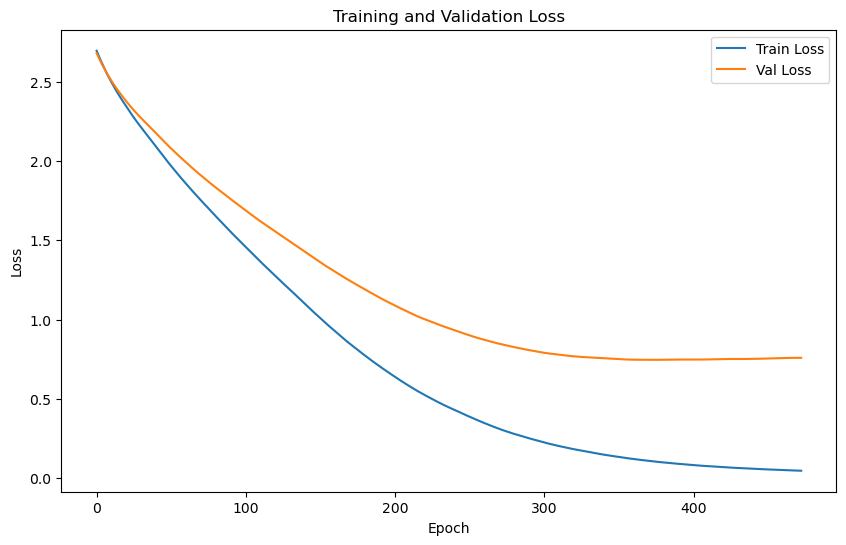

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.3996 | Test Accuracy: 77.37%


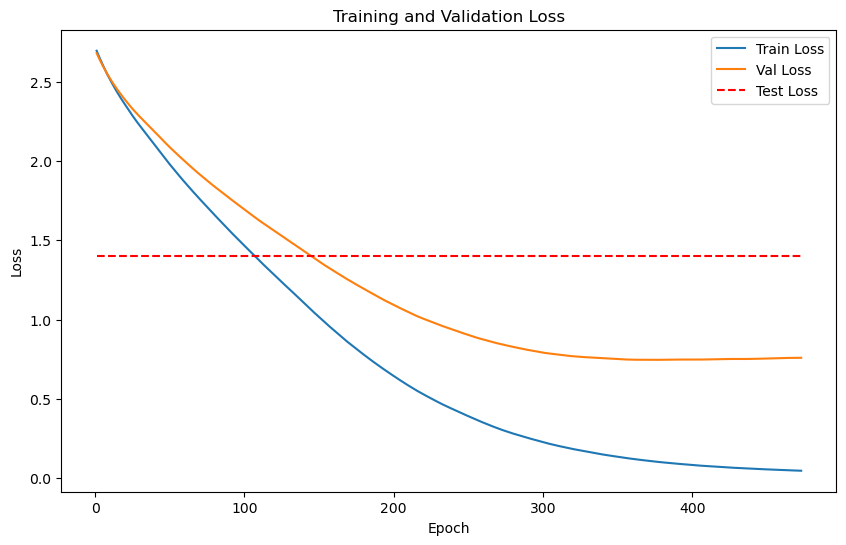

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


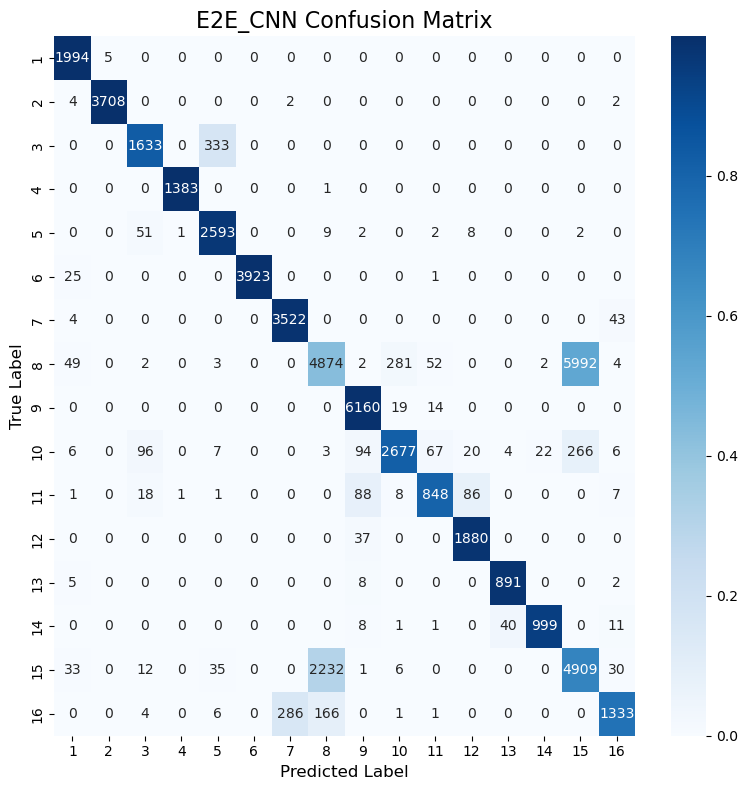

Classification Accuracy: 80.28%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


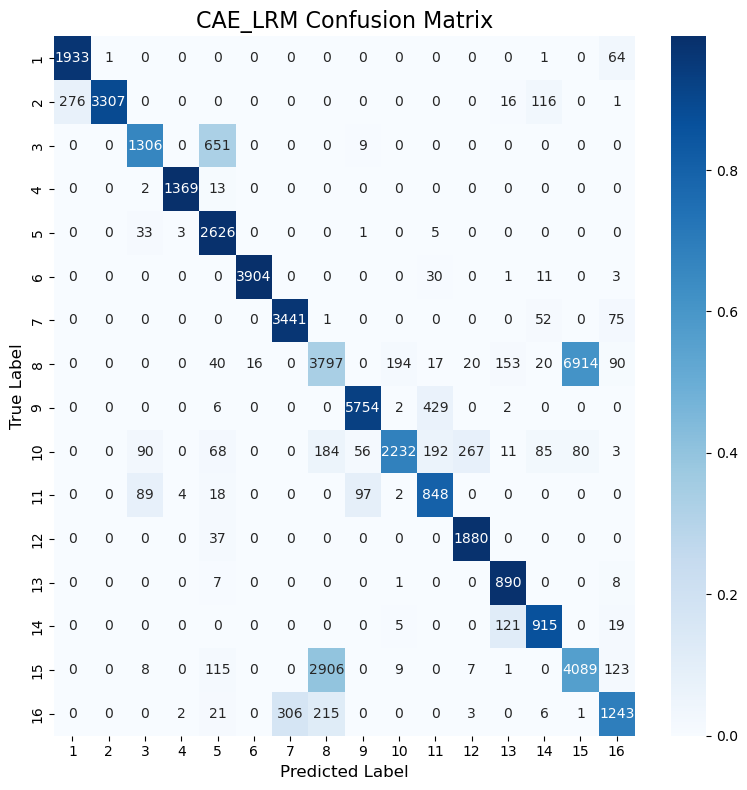

Classification Accuracy: 73.25%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


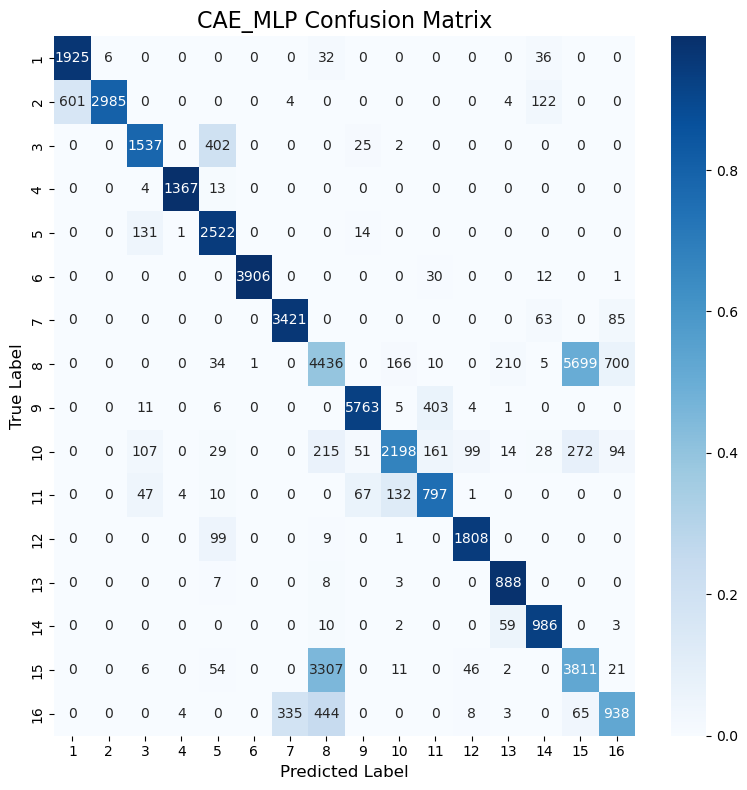

Classification Accuracy: 72.80%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


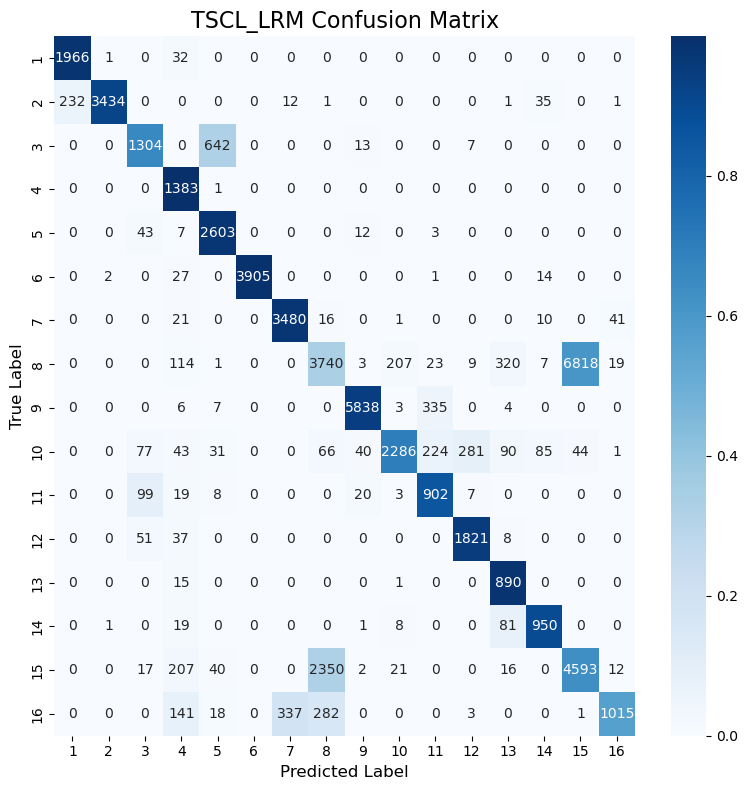

Classification Accuracy: 74.32%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


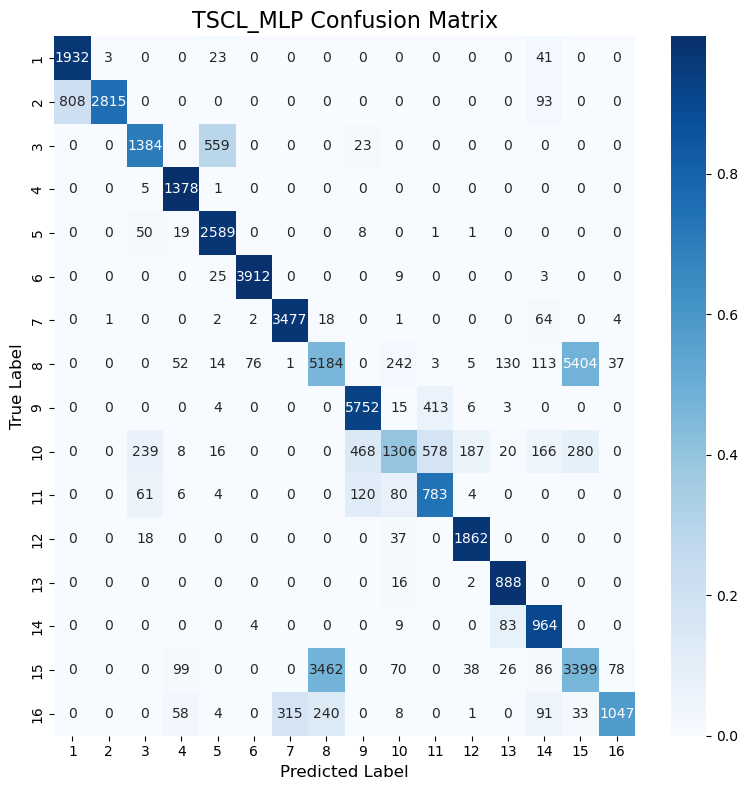

Classification Accuracy: 71.66%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


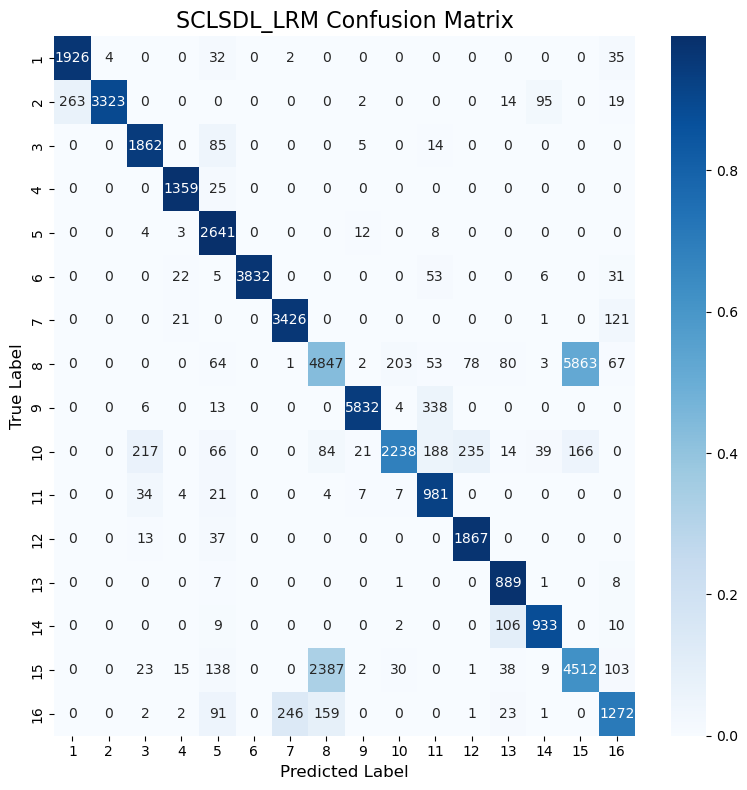

Classification Accuracy: 77.34%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


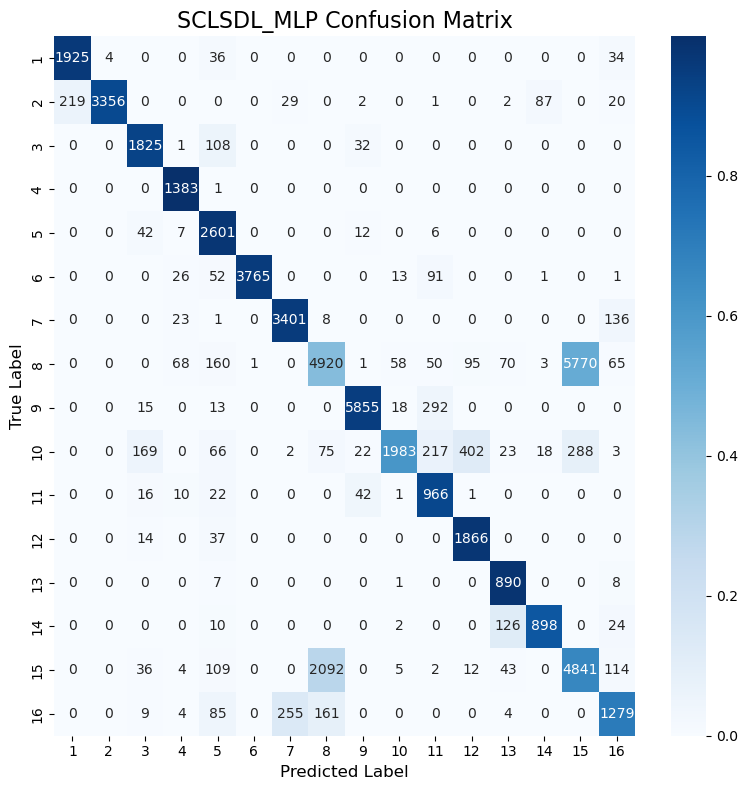

Classification Accuracy: 77.37%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          80.28
1    LRM (CAE)          73.25
2    MLP (CAE)          72.80
3     TSCL LRM          74.32
4     TSCL MLP          71.66
5  SCL_SDL LRM          77.34
6  SCL_SDL MLP          77.37

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          80.28
6  SCL_SDL MLP          77.37
5  SCL_SDL LRM          77.34
3     TSCL LRM          74.32
1    LRM (CAE)          73.25
2    MLP (CAE)          72.80
4     TSCL MLP          71.66
